Import All Required Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.15.0'

Load the MNIST DataSet.
MNIST is a popular dataset consisting of handwritten digits (0 through 9)


In [3]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


X_train contains 60,000 images, each with dimensions 28x28 pixels. y_train is a 1-dimensional array with 60,000 elements. Each element represents the label (i.e., the digit from 0 to 9)

In [4]:
X_train.shape

(60000, 28, 28)

In [5]:
y_train.shape

(60000,)

8


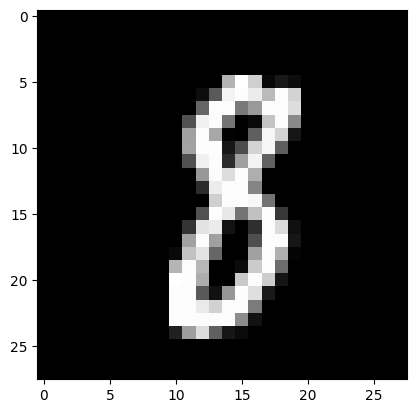

In [6]:
i = np.random.randint(0,60000)
#print(i)
print(y_train[i])
plt.imshow(X_train[i], cmap = 'gray')

In [7]:
#  1 in the 4th parameter represents there is only 1 channel in image (grayscale)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_train.shape

(60000, 28, 28, 1)

In [8]:
X_train[0].min(), X_train[0].max()

(0.0, 255.0)

In [9]:
X_train = (X_train-127.5)/127.5
X_train[0].min(), X_train[0].max()

(-1.0, 1.0)

In [10]:
buffer_size = 60000
batch_size = 256

# Mini Batch Gradient Descent Algorithm : divides the data into mini batches of fixed sizes.
# The model parameters are then updated based on the average gradient computed from each mini-batch.

In [11]:
type(X_train)

numpy.ndarray

In [12]:
#shuffles the images to randomize the order and then baches into mini batches for improved training efficiency
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [13]:
type(X_train)

tensorflow.python.data.ops.batch_op._BatchDataset

In [14]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [15]:
def build_generator():
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides=(2,2), use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides=(2,2), use_bias = True, activation = 'tanh'))

  network.summary()
  return network

In [16]:
generator = build_generator()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [17]:
generator.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

In [18]:
noise = tf.random.normal([1,100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.586019  , -0.45917907, -0.7839247 , -0.37076858,  0.2068434 ,
         1.7874976 ,  0.11649236, -0.90819615,  1.5186085 , -1.925004  ,
         0.89125353,  0.12288629,  0.1171473 ,  0.6177374 ,  1.9011858 ,
         1.6864364 , -0.6466481 ,  0.86136204, -0.57315964,  0.0080671 ,
        -1.1070855 , -1.1064422 ,  0.37658527, -0.6030372 , -0.9998809 ,
         0.10609052, -0.40630624,  1.6823621 , -0.7705151 ,  0.69571817,
        -0.75893855,  0.0566422 , -0.01385756, -0.6072236 , -0.37349844,
         1.2238243 ,  2.1459956 , -0.12482495,  0.24624285, -1.255358  ,
        -1.0450293 ,  1.9218785 , -0.5386238 ,  0.4063552 ,  0.11304972,
        -0.516787  , -0.7628675 , -0.9923976 ,  1.4074105 , -0.32505843,
        -0.09849907, -1.2089213 , -0.44650093, -0.8083368 , -0.24704267,
        -0.7910359 ,  1.0089585 ,  1.493463  , -1.0821629 ,  1.748725  ,
         0.7644876 ,  0.43028873,  0.37567917,  0.29527304,  1.9322952 ,
 

In [19]:
generated_image = generator(noise, training=False)

In [20]:
generated_image.shape

TensorShape([1, 28, 28, 1])

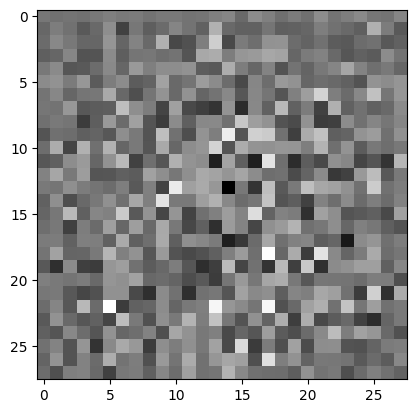

In [21]:
plt.imshow(generated_image[0,:,:,0], cmap = 'gray')

In [22]:
def build_discriminator():
  network = tf.keras.Sequential()

  network.add(layers.Conv2D(filters = 64, strides=(2,2), kernel_size=(5,5), padding = 'same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Conv2D(filters = 128, strides=(2,2), kernel_size=(5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()
  return network


In [23]:
discriminator = build_discriminator()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [24]:
discriminator.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

In [25]:
discriminator(generated_image, training=False)  #logits form


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00170265]], dtype=float32)>

In [26]:
tf.sigmoid(0.00145083)  #converts to probability

<tf.Tensor: shape=(), dtype=float32, numpy=0.5003627>

In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [29]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=.00001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=.00001)


In [31]:
X_train

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [32]:
epochs = 100
noise_dimension = 100
number_of_images = 16

In [33]:
batch_size, noise_dimension

(256, 100)

In [49]:
@tf.function
def train(images):
  noise = tf.random.normal([batch_size, noise_dimension])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training = True)

    expected_output = discriminator(images, training = True)
    fake_output = discriminator(generated_images, training = True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)

  generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [50]:
test_images = tf.random.normal([number_of_images, noise_dimension])
test_images.shape

TensorShape([16, 100])

In [60]:
def train_gan(dataset, epochs, test_images):
  for epoch in range(epochs):
    #print(epoch)
    for image_batch in dataset:
      #print(image_batch.shape)
      train(image_batch)

    print('Epoch: ', epoch + 1)
    generated_images = generator(test_images, training = False)
    fig = plt.figure(figsize = (10,10))
    for i in range(generated_images.shape[0]):
      plt.subplot(4,4,i + 1)
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

Epoch:  1


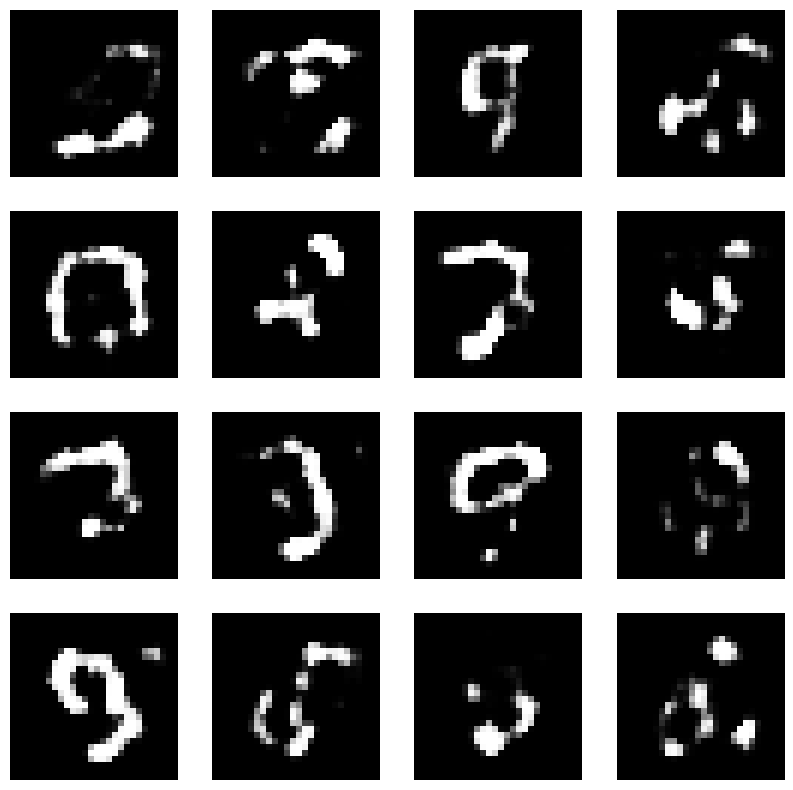

Epoch:  2


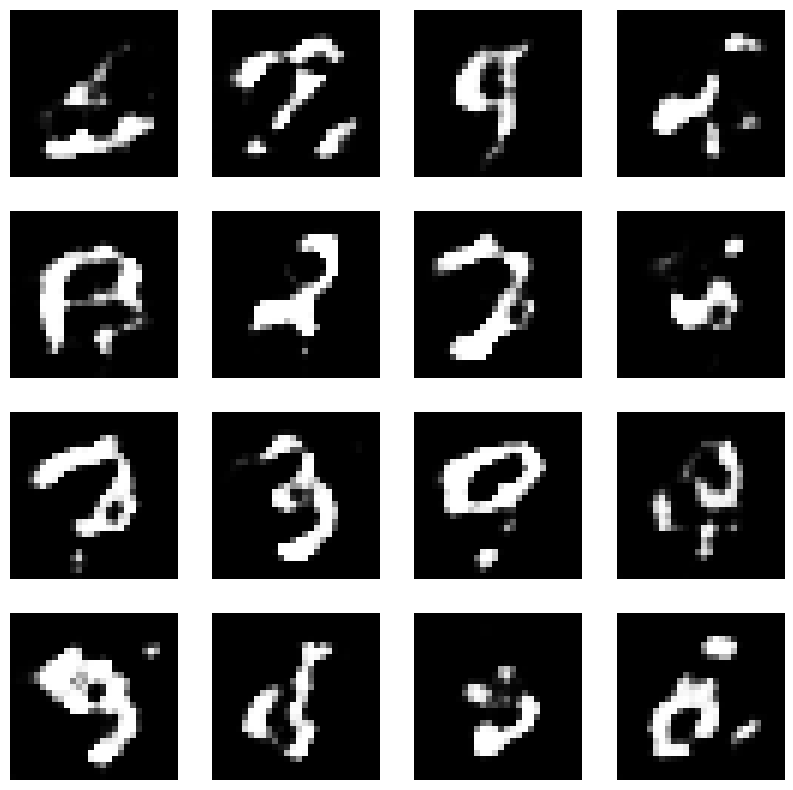

Epoch:  3


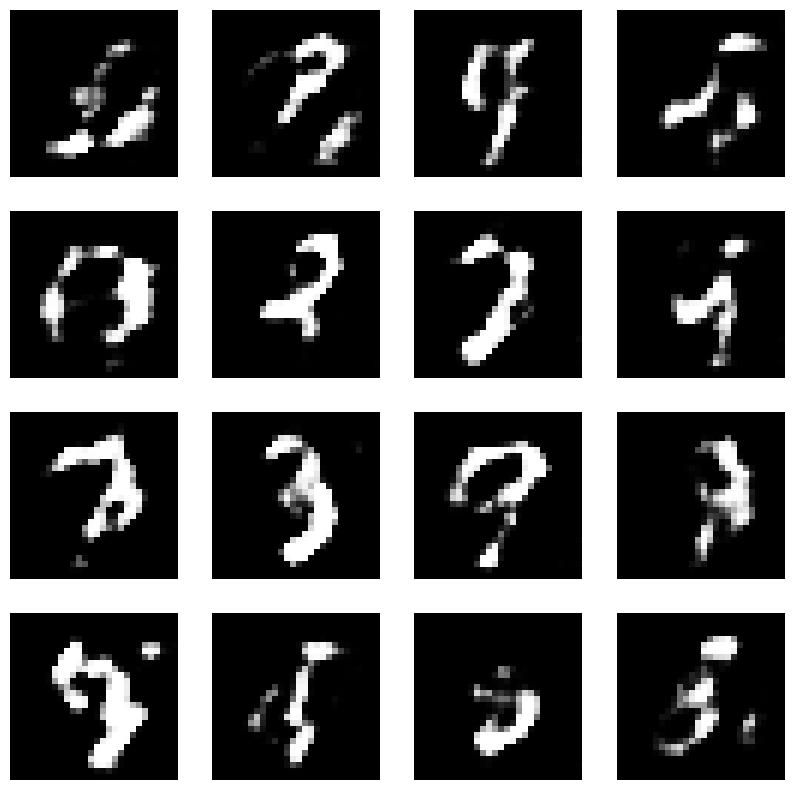

Epoch:  4


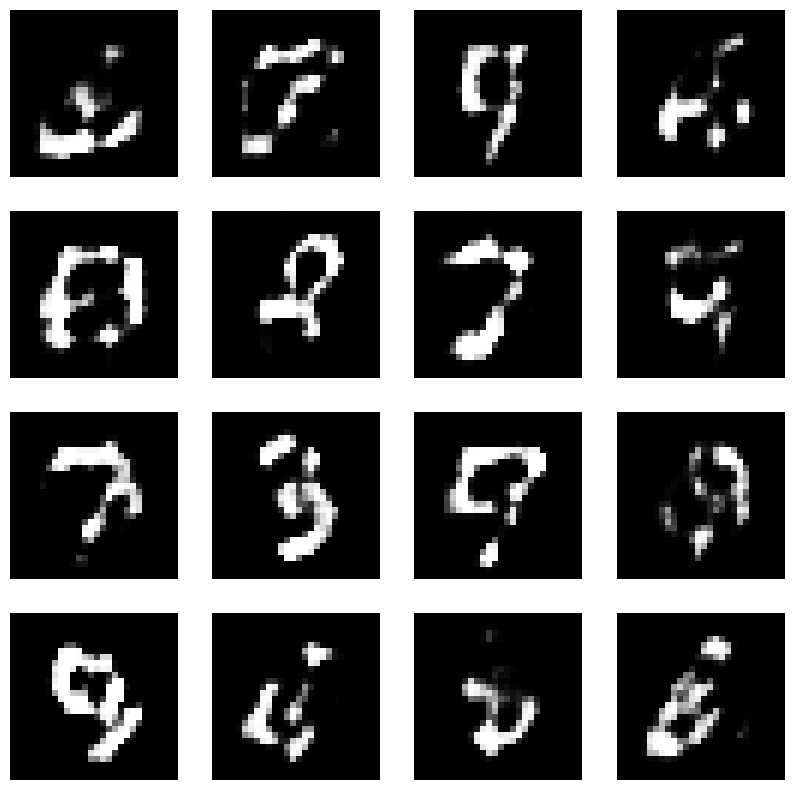

Epoch:  5


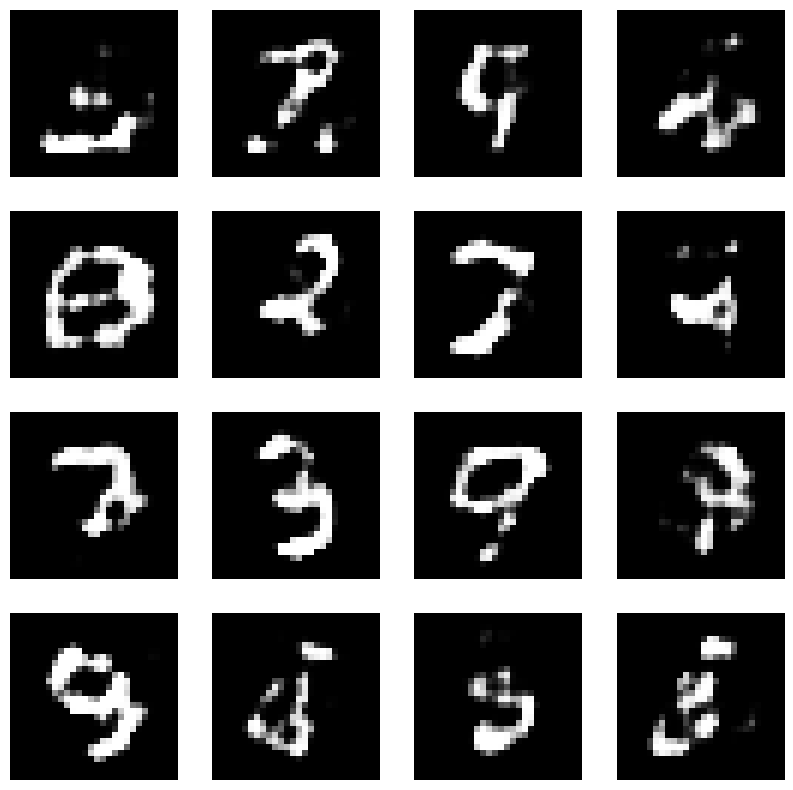

Epoch:  6


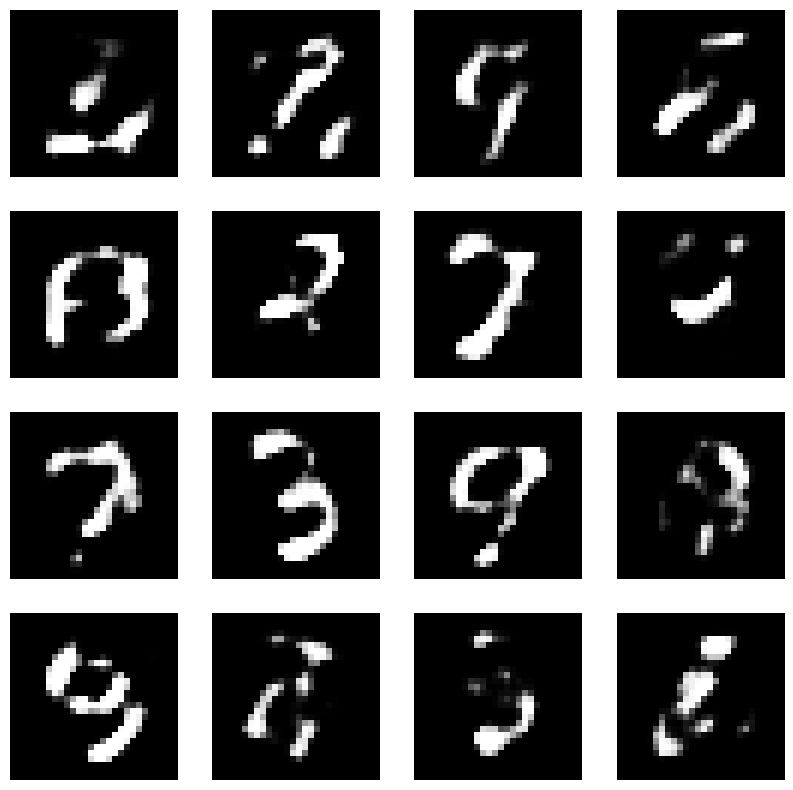

Epoch:  7


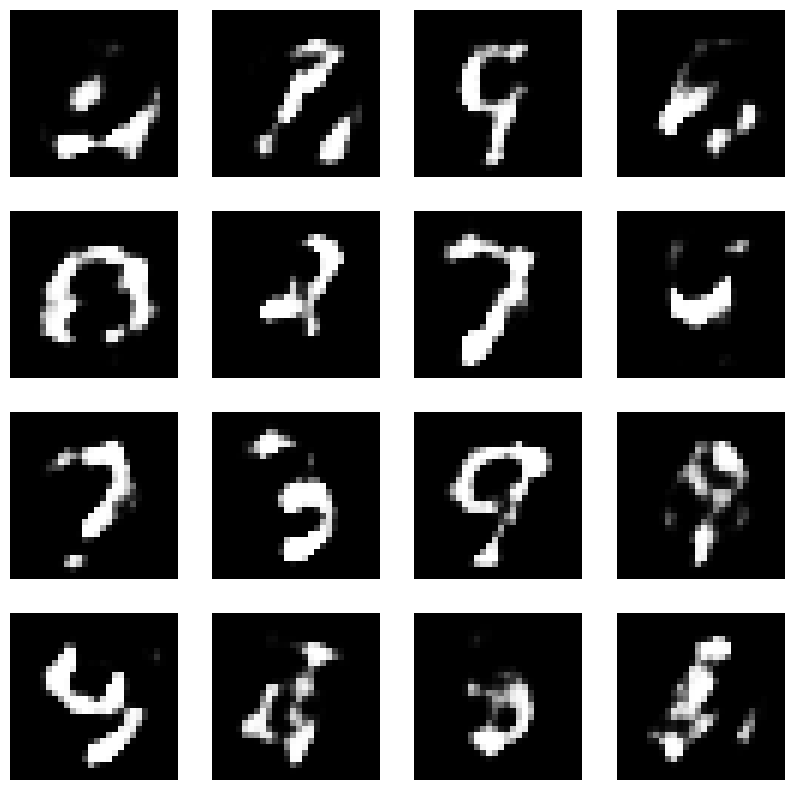

Epoch:  8


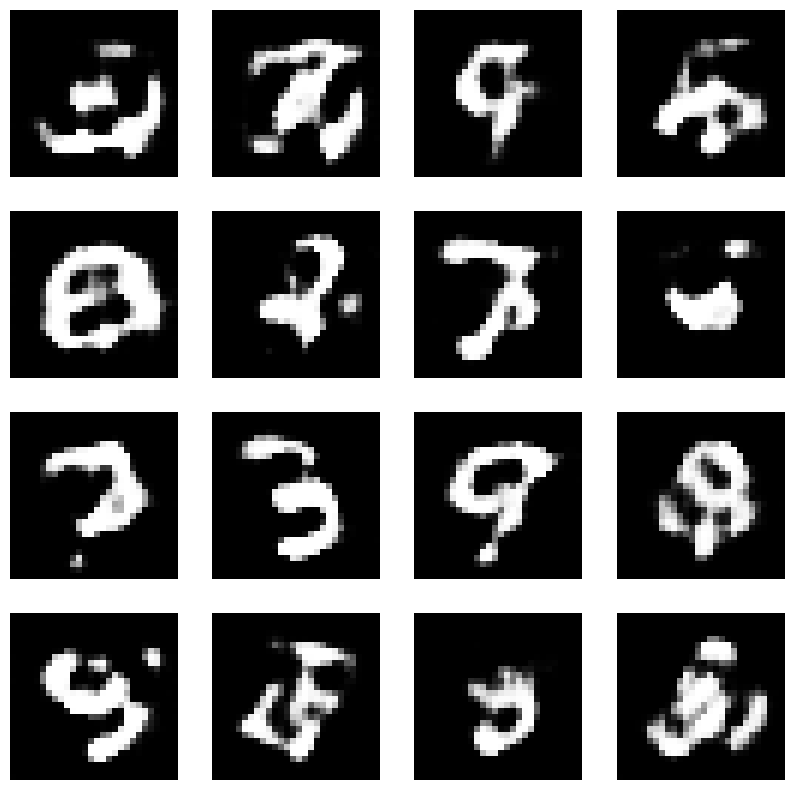

Epoch:  9


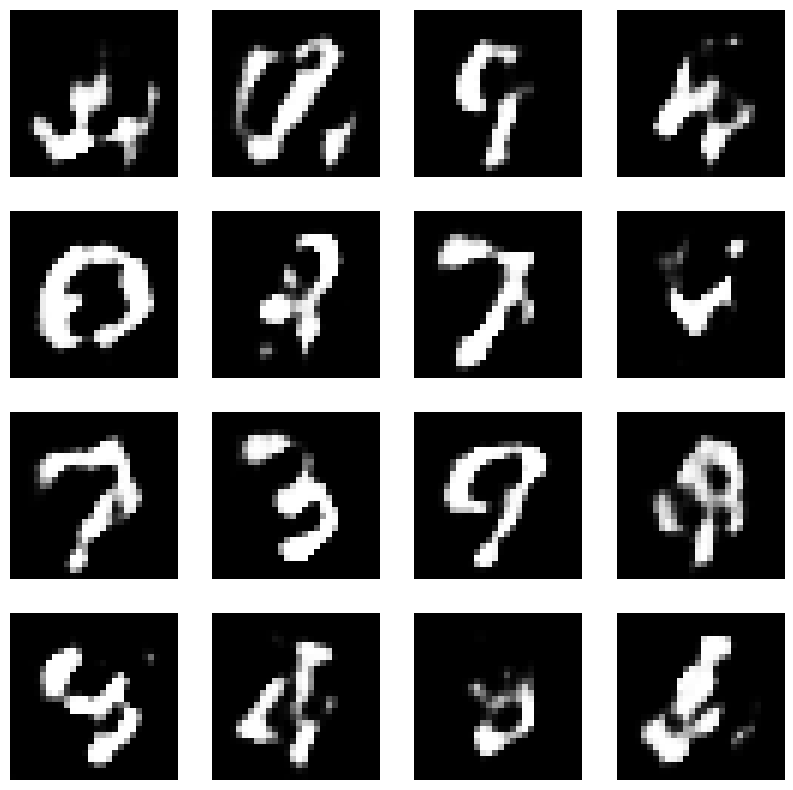

Epoch:  10


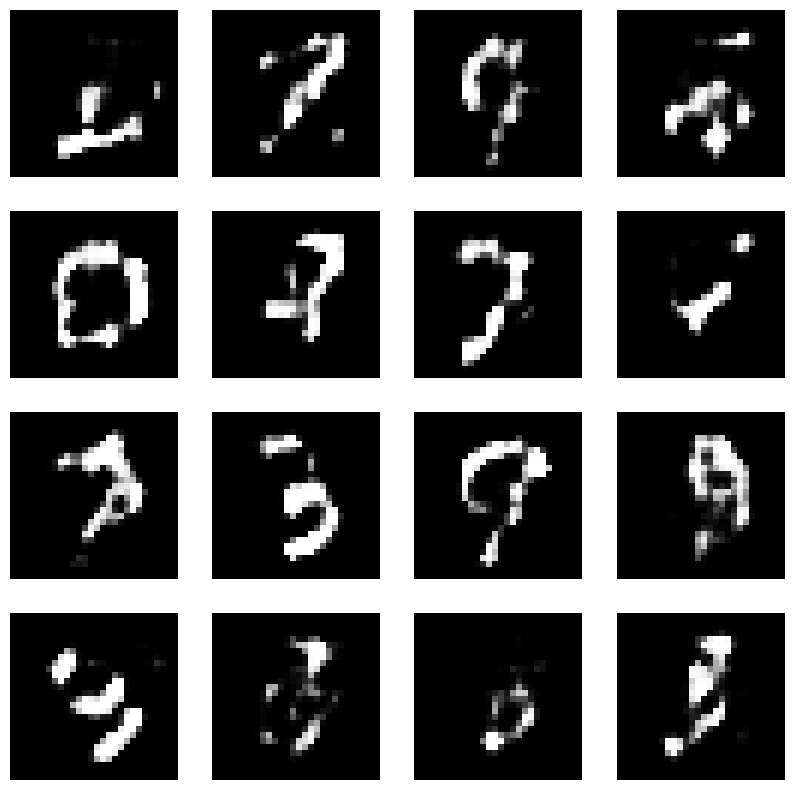

Epoch:  11


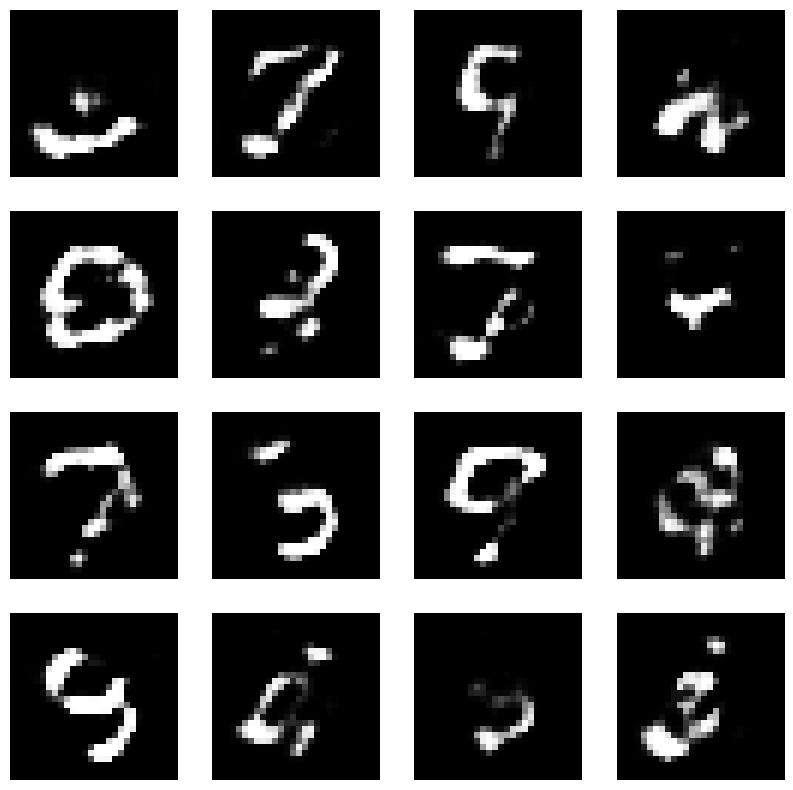

Epoch:  12


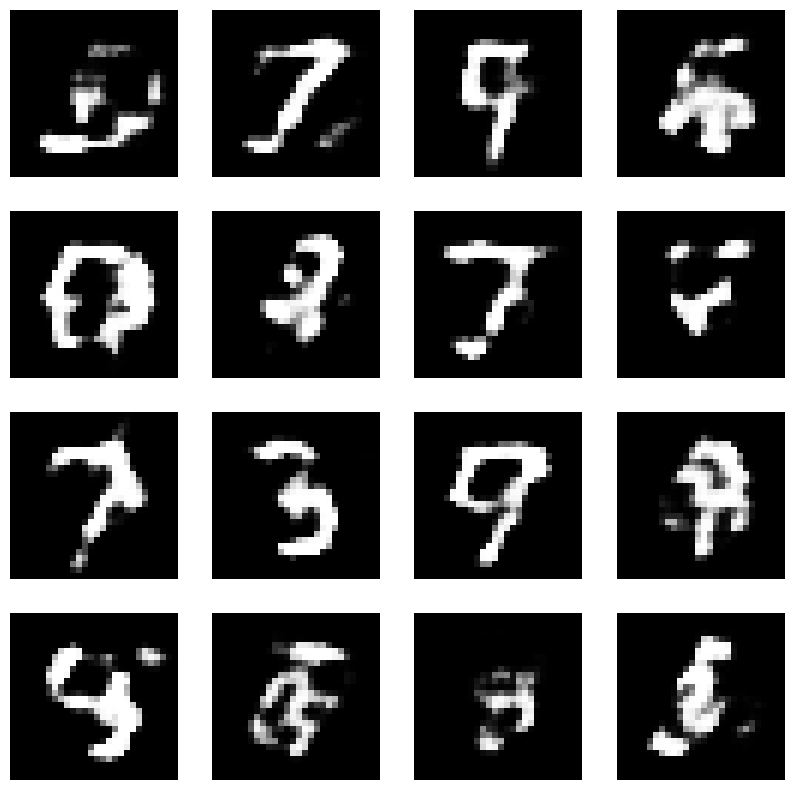

Epoch:  13


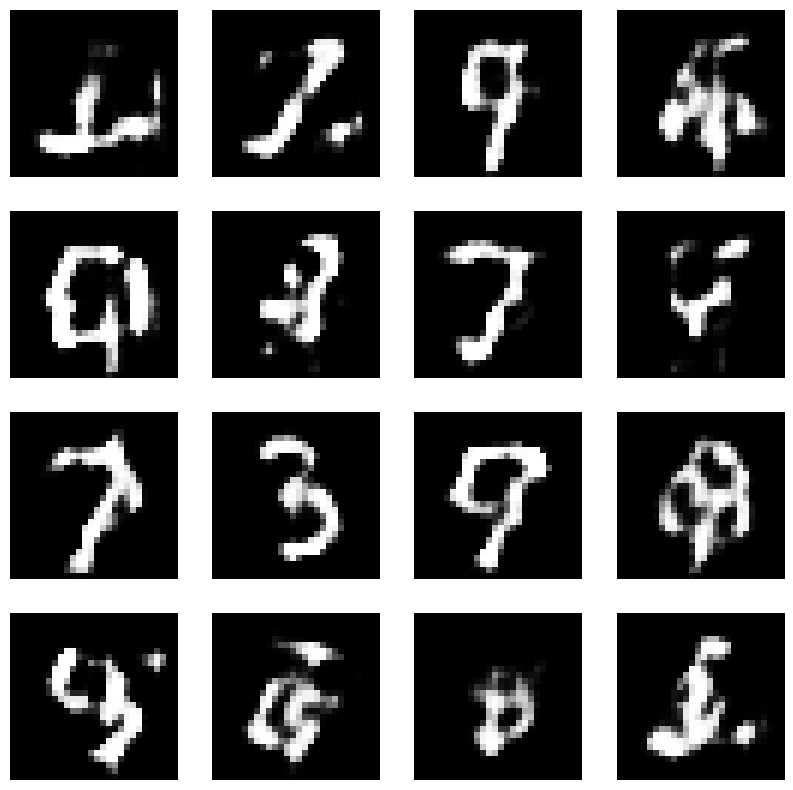

Epoch:  14


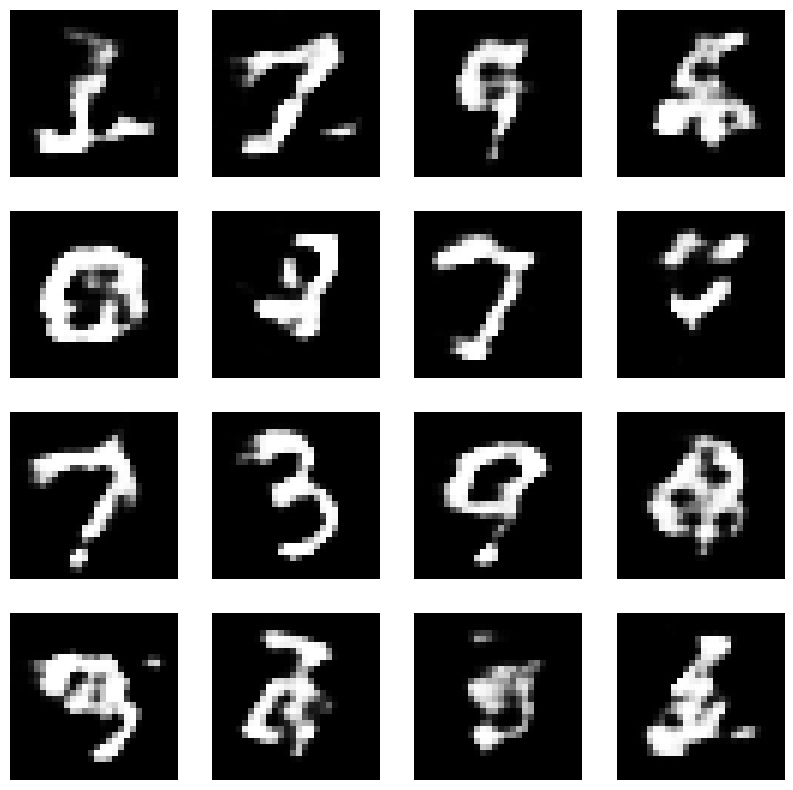

Epoch:  15


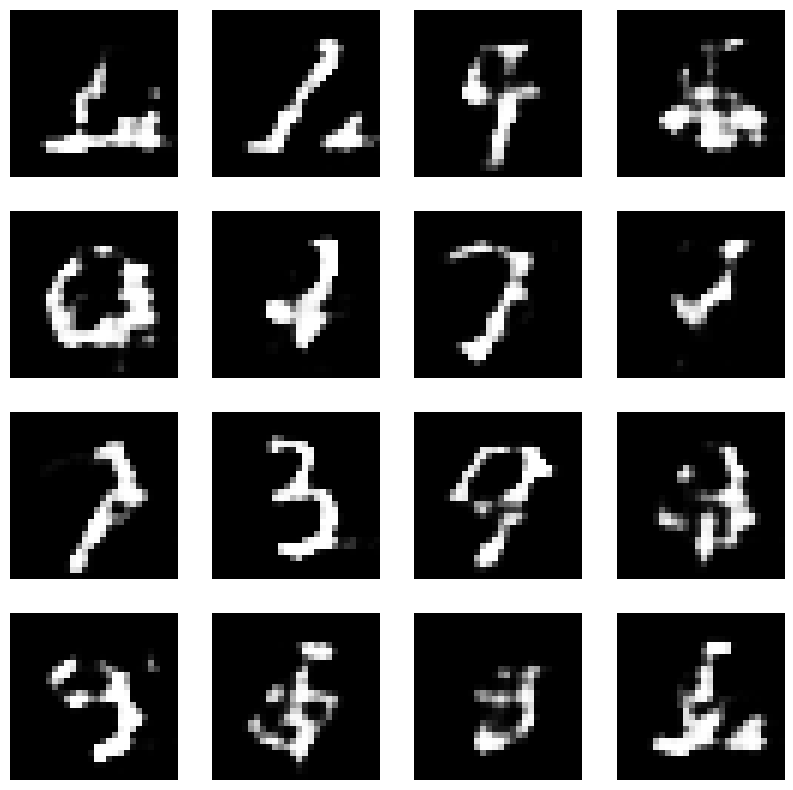

Epoch:  16


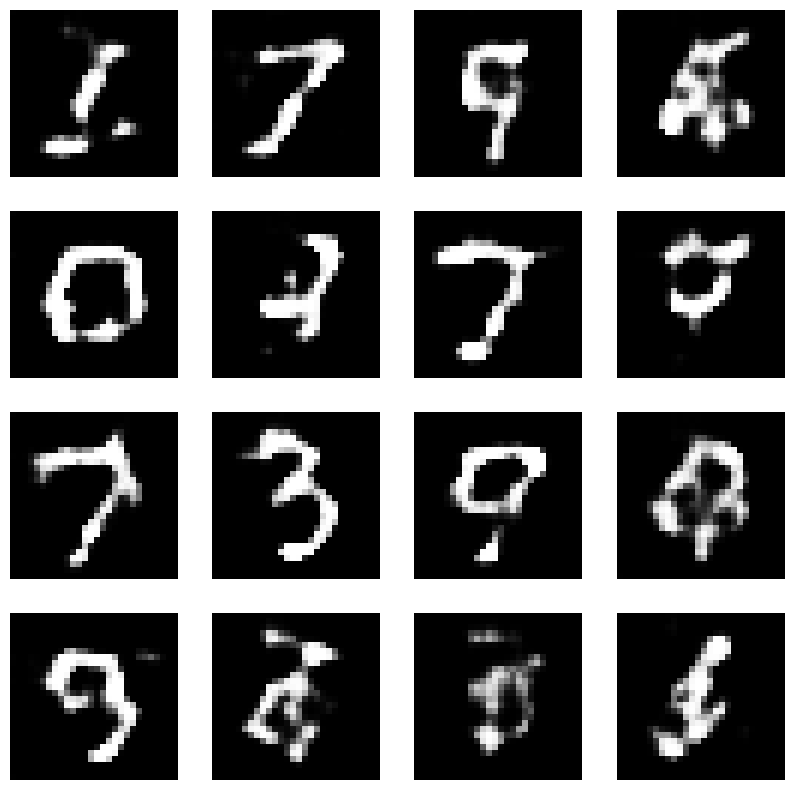

Epoch:  17


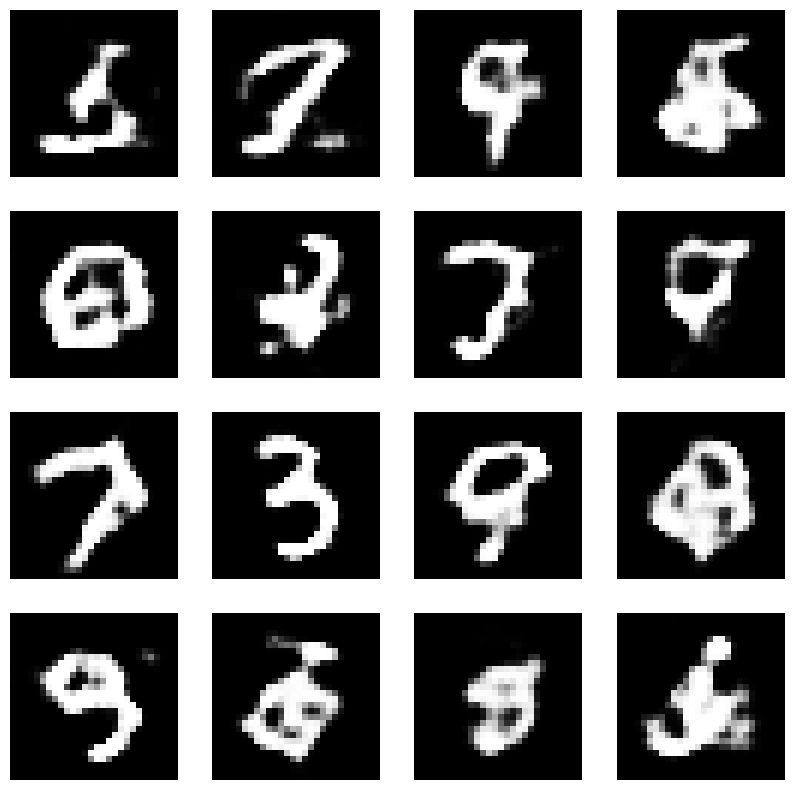

Epoch:  18


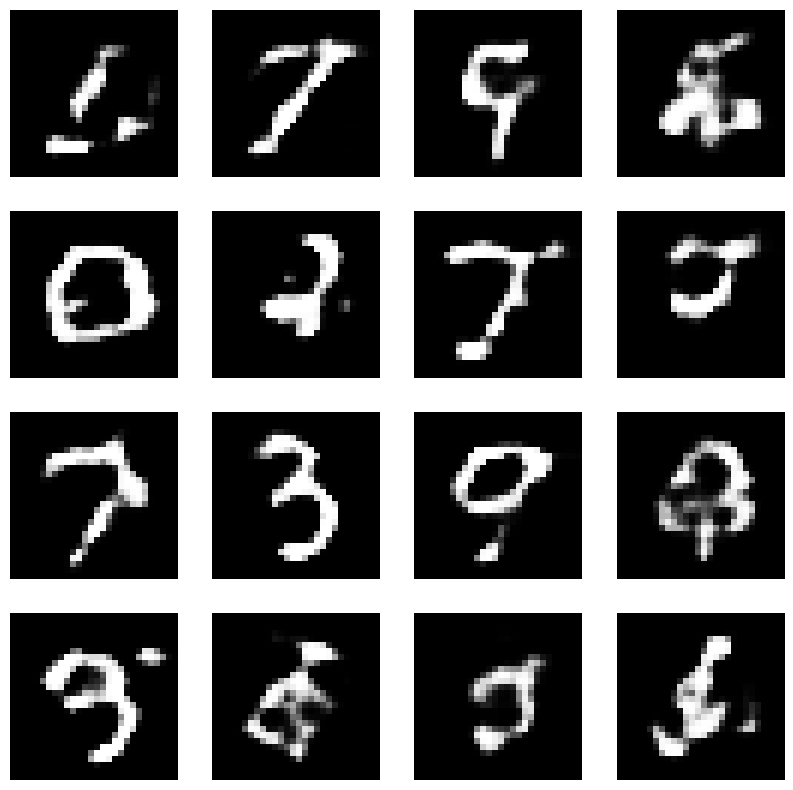

Epoch:  19


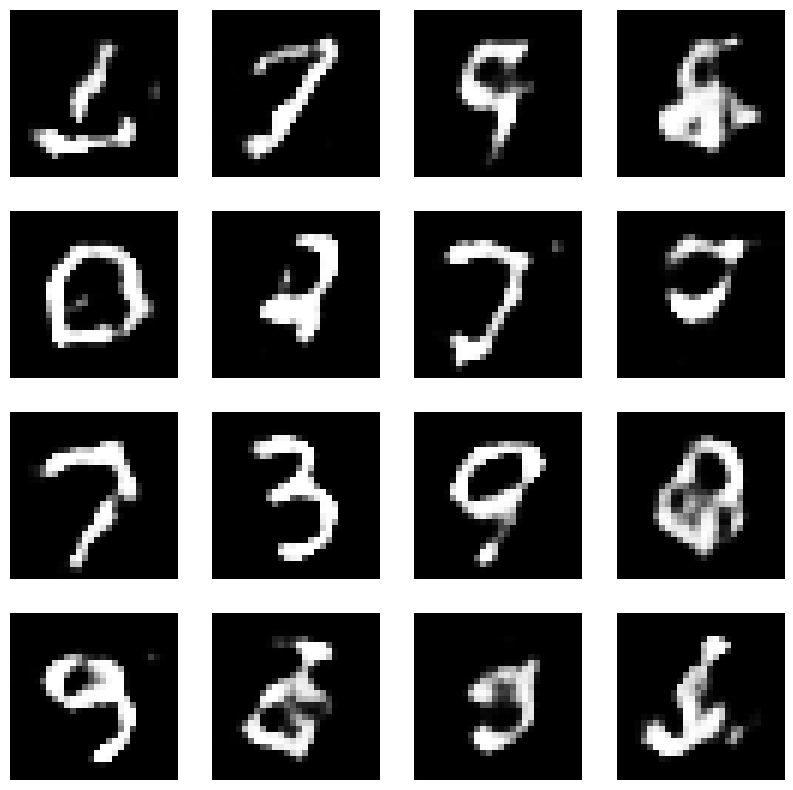

Epoch:  20


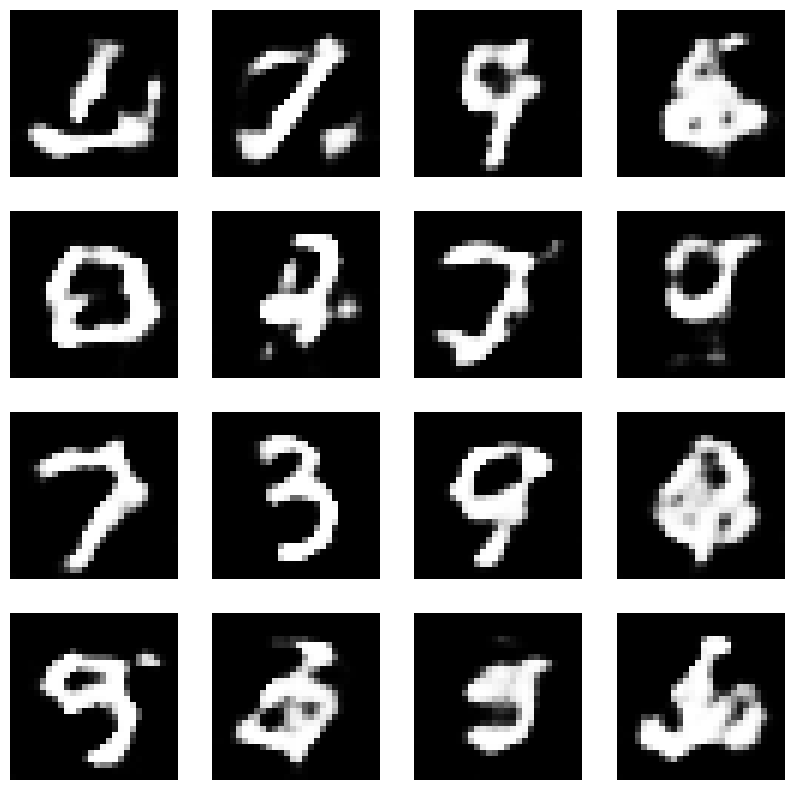

Epoch:  21


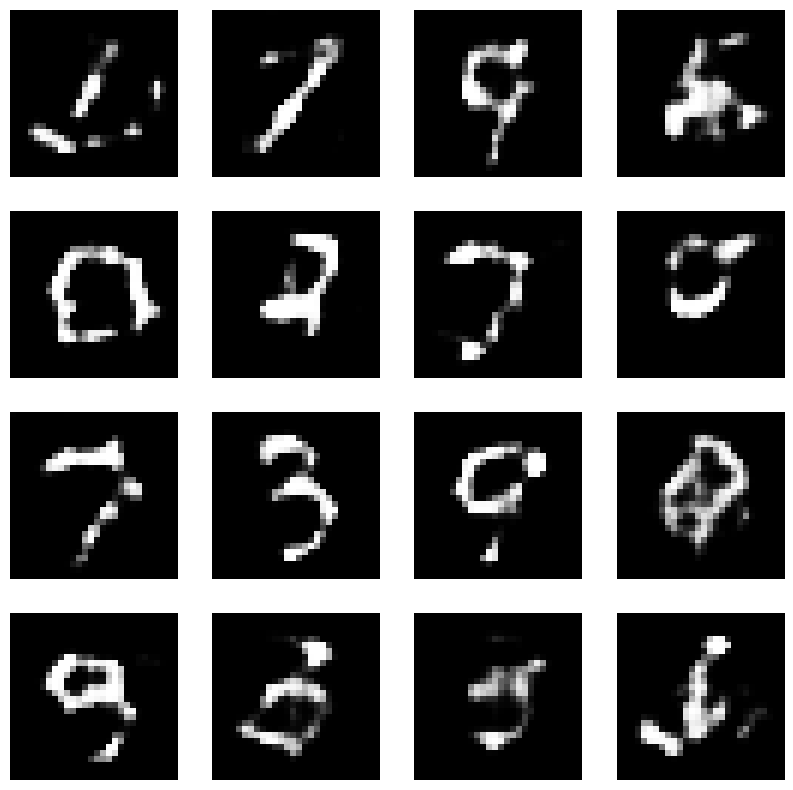

Epoch:  22


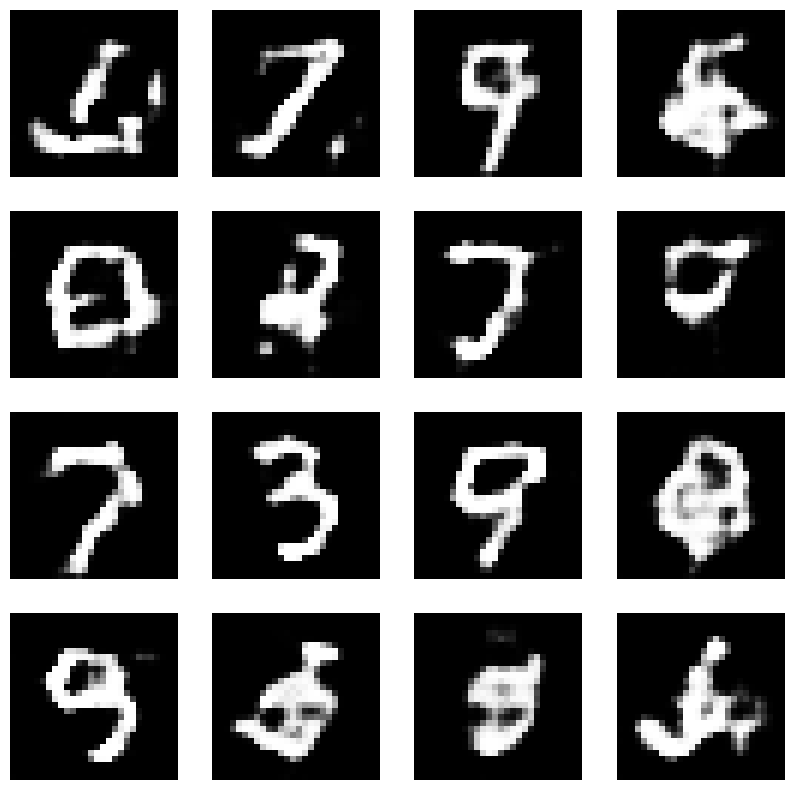

Epoch:  23


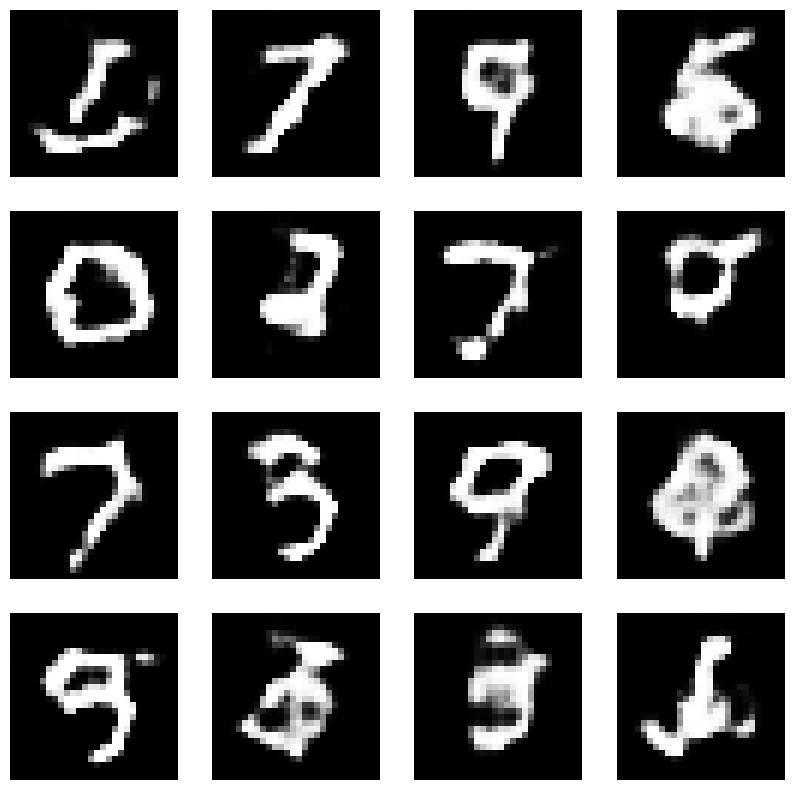

Epoch:  24


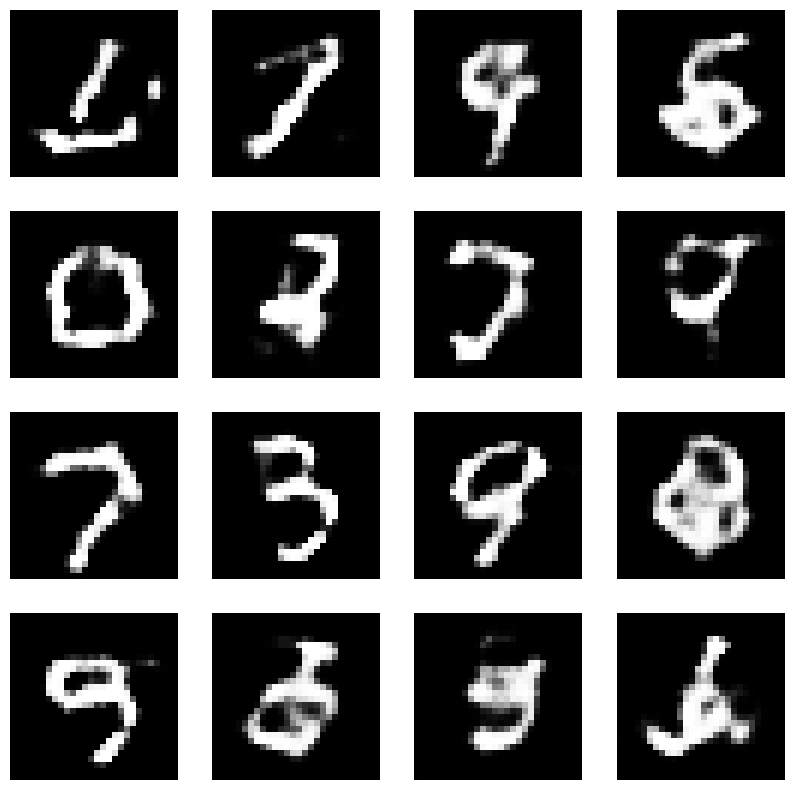

Epoch:  25


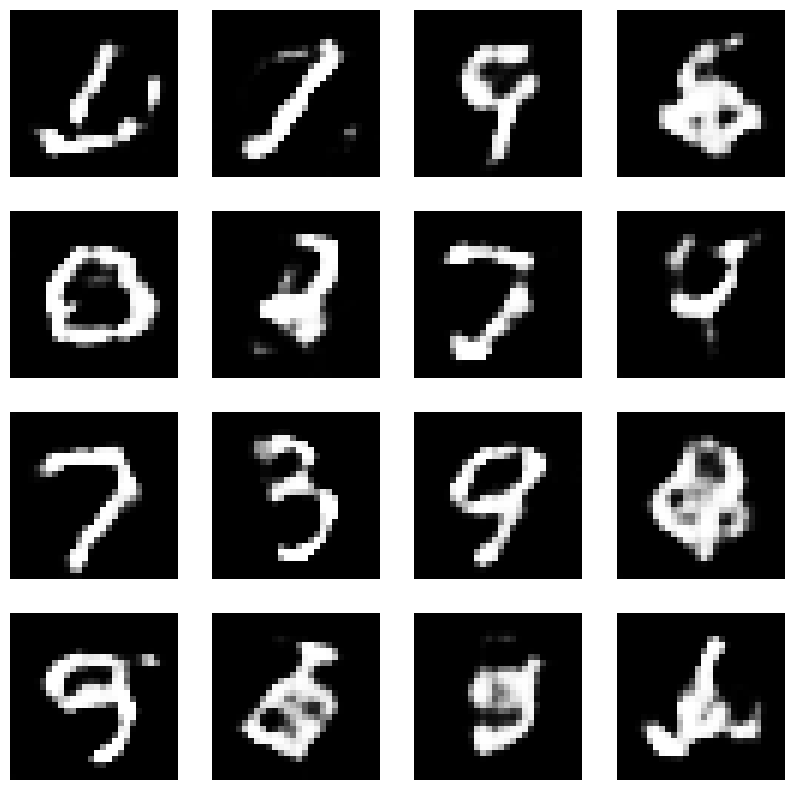

Epoch:  26


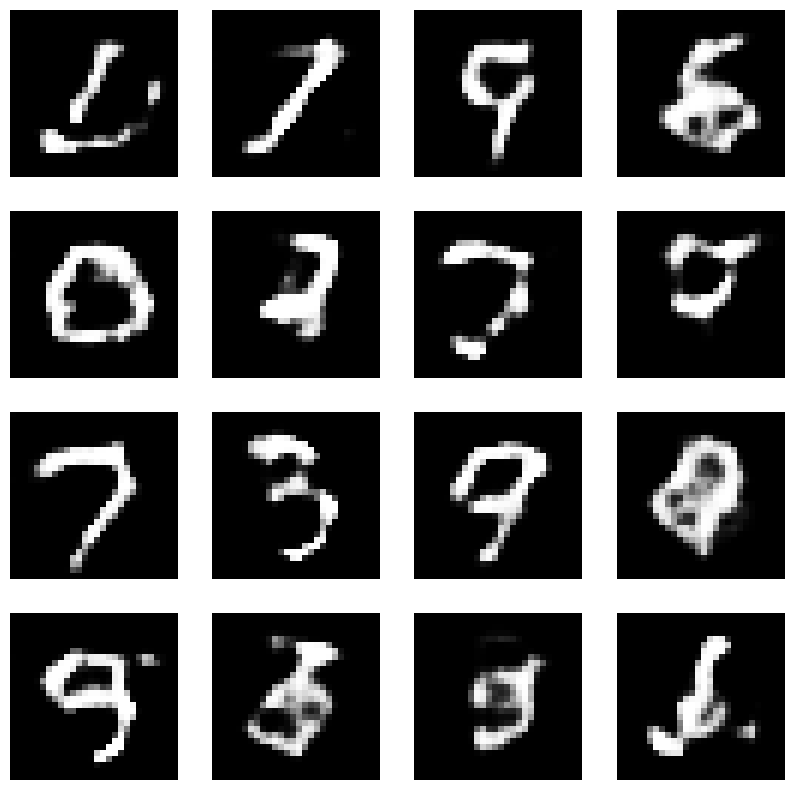

Epoch:  27


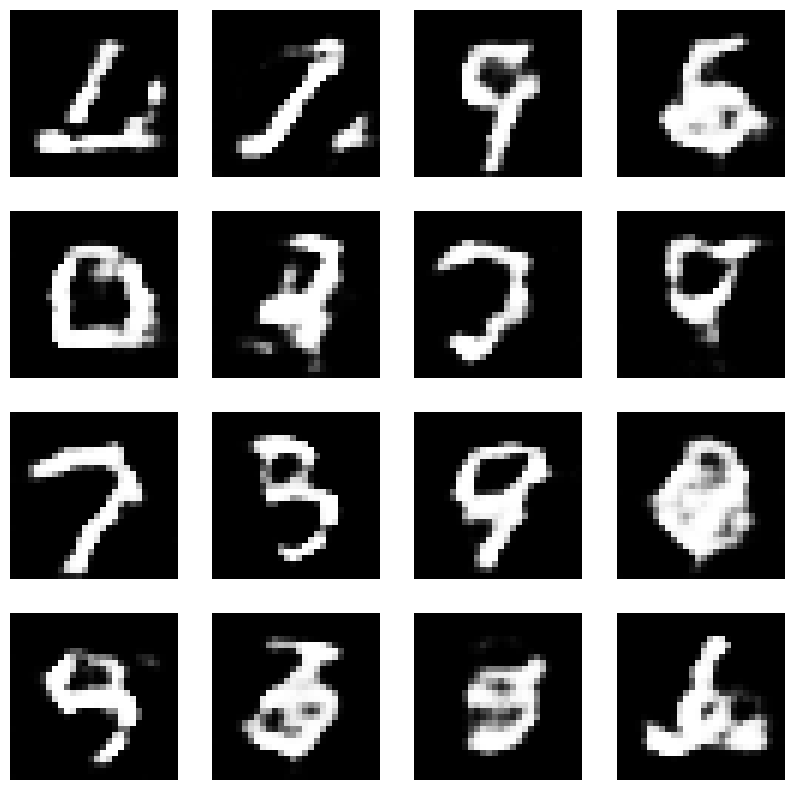

Epoch:  28


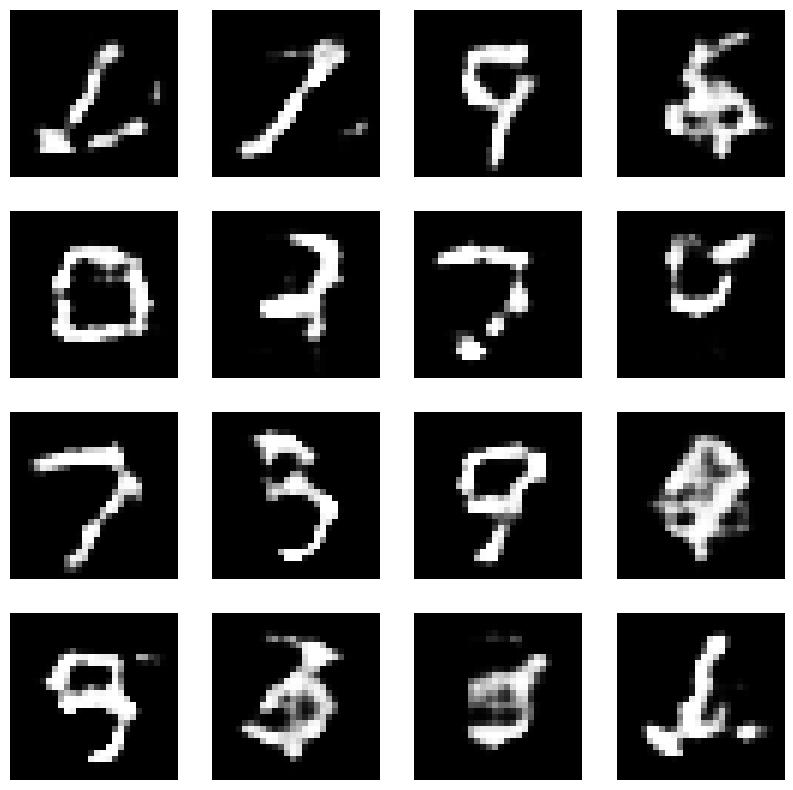

Epoch:  29


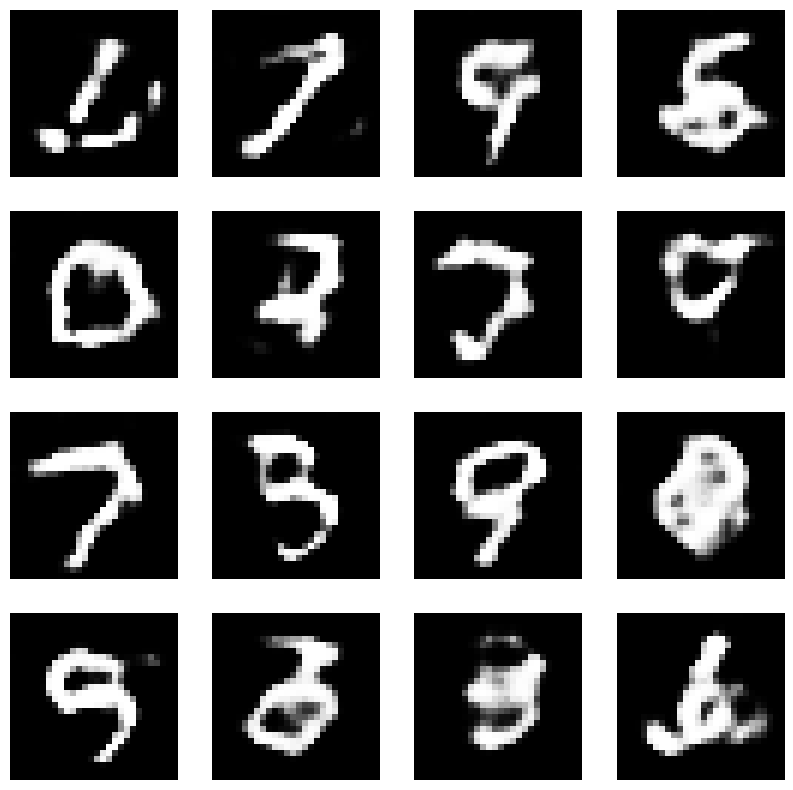

Epoch:  30


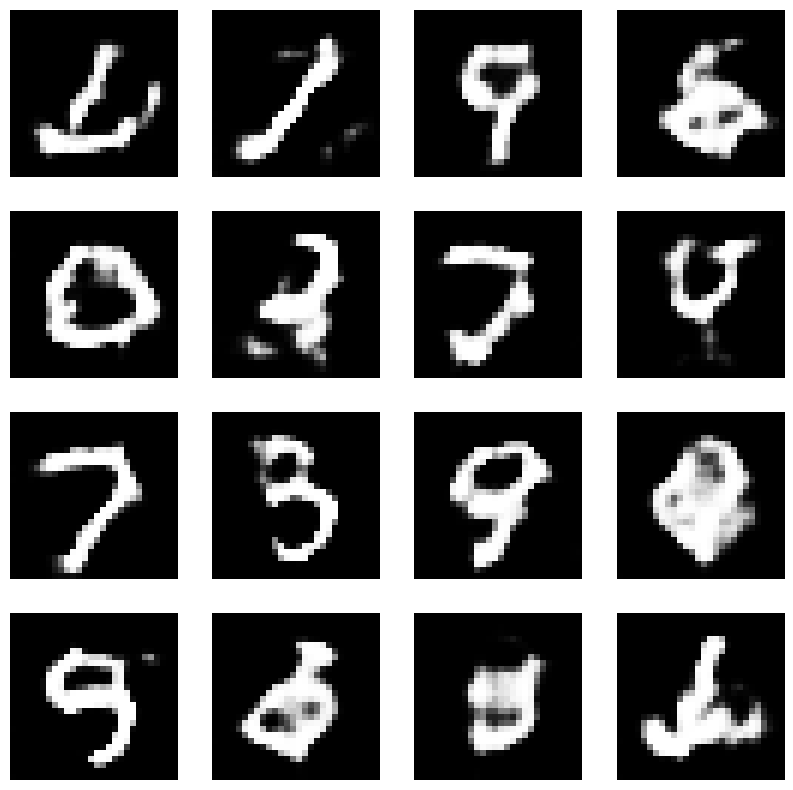

Epoch:  31


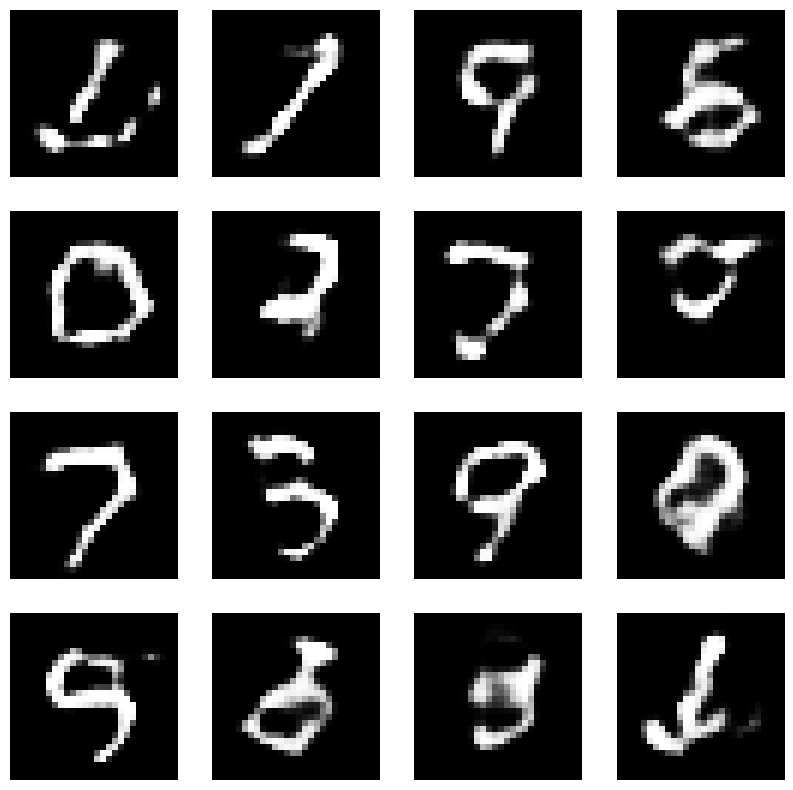

Epoch:  32


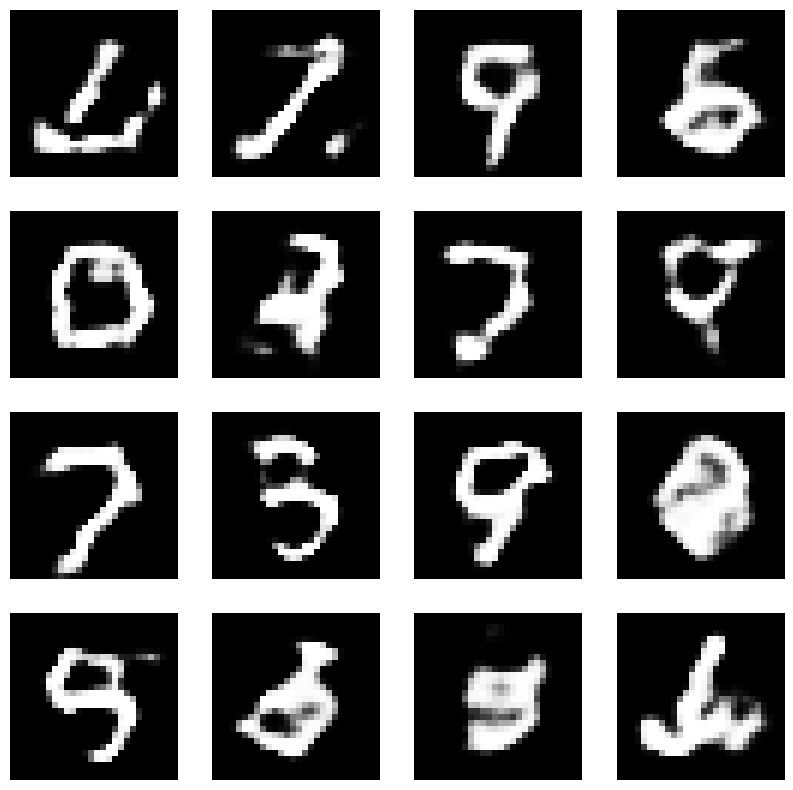

Epoch:  33


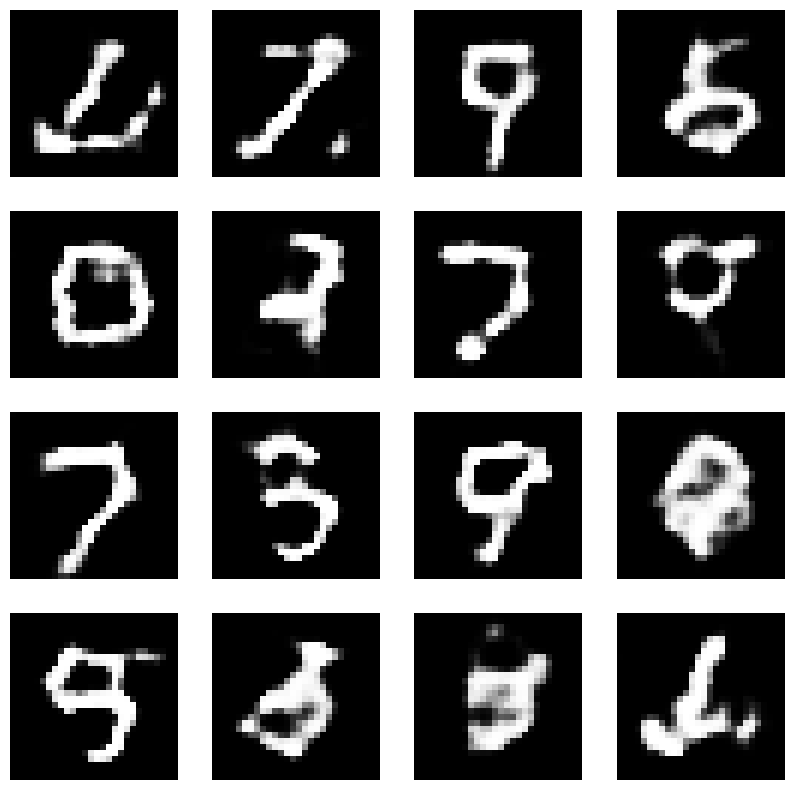

Epoch:  34


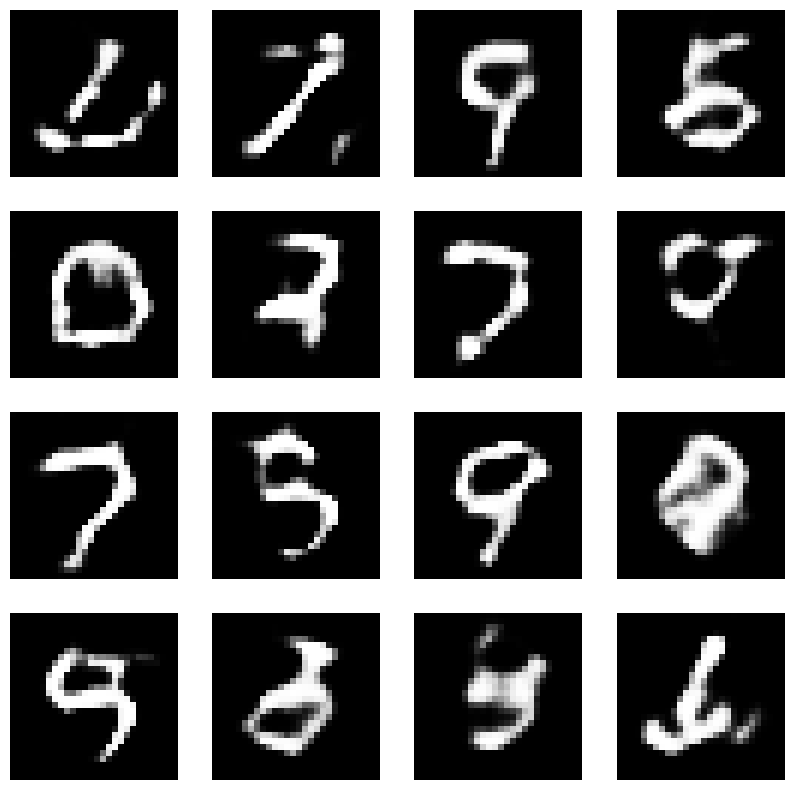

Epoch:  35


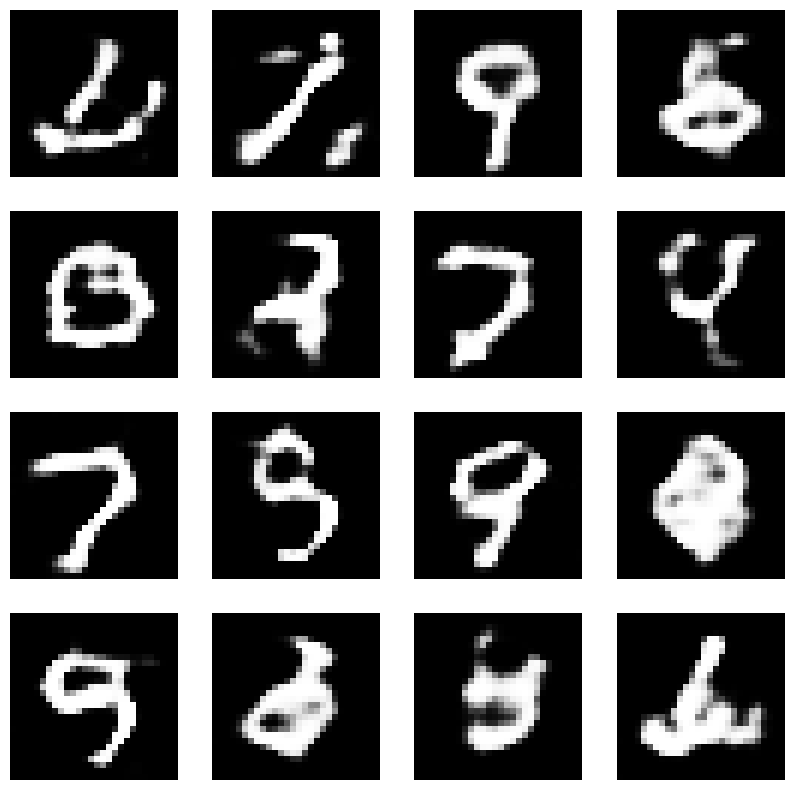

Epoch:  36


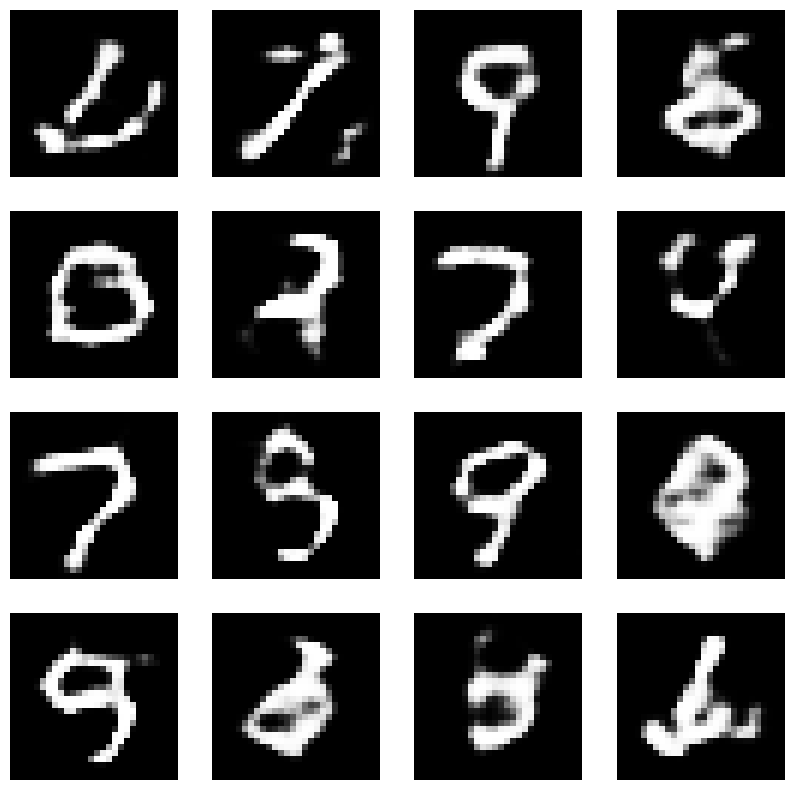

Epoch:  37


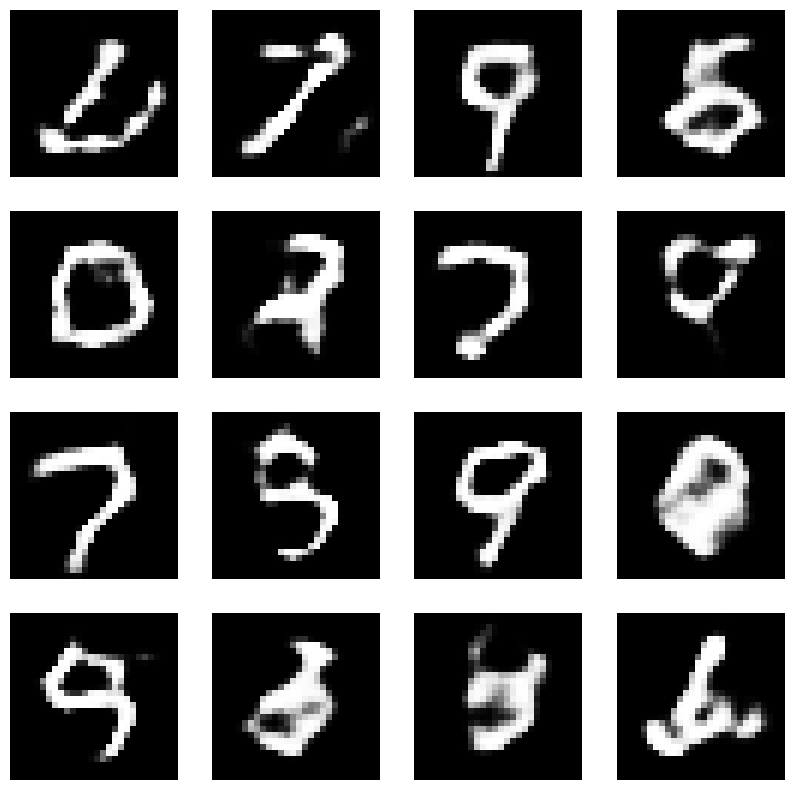

Epoch:  38


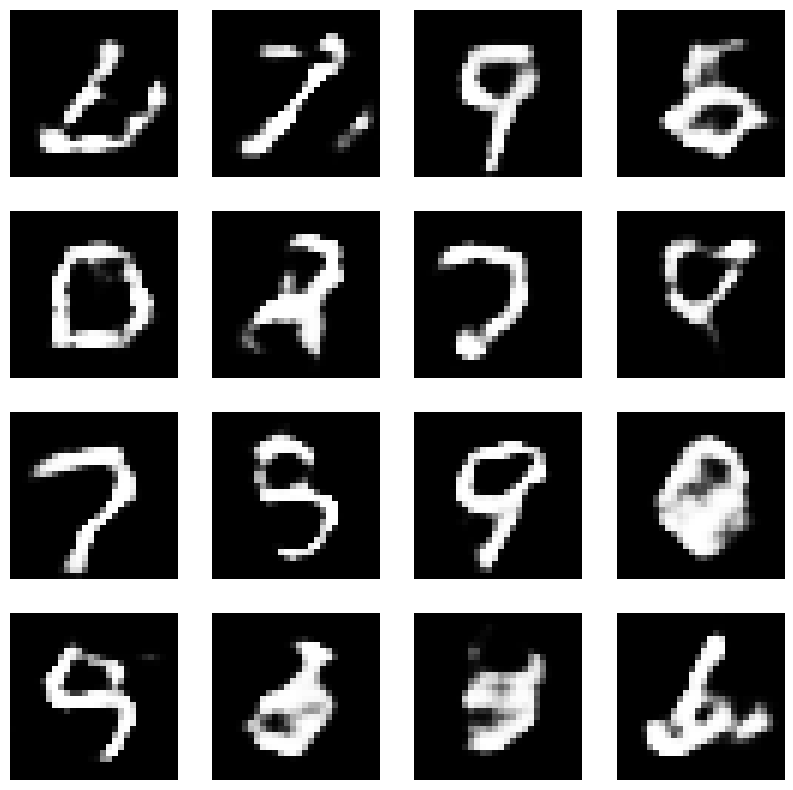

Epoch:  39


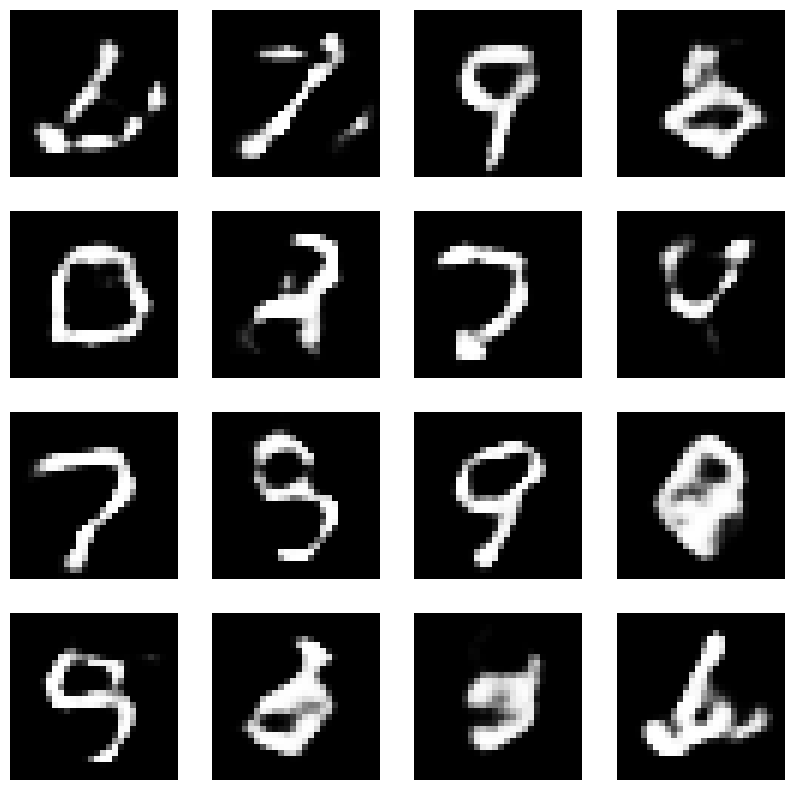

Epoch:  40


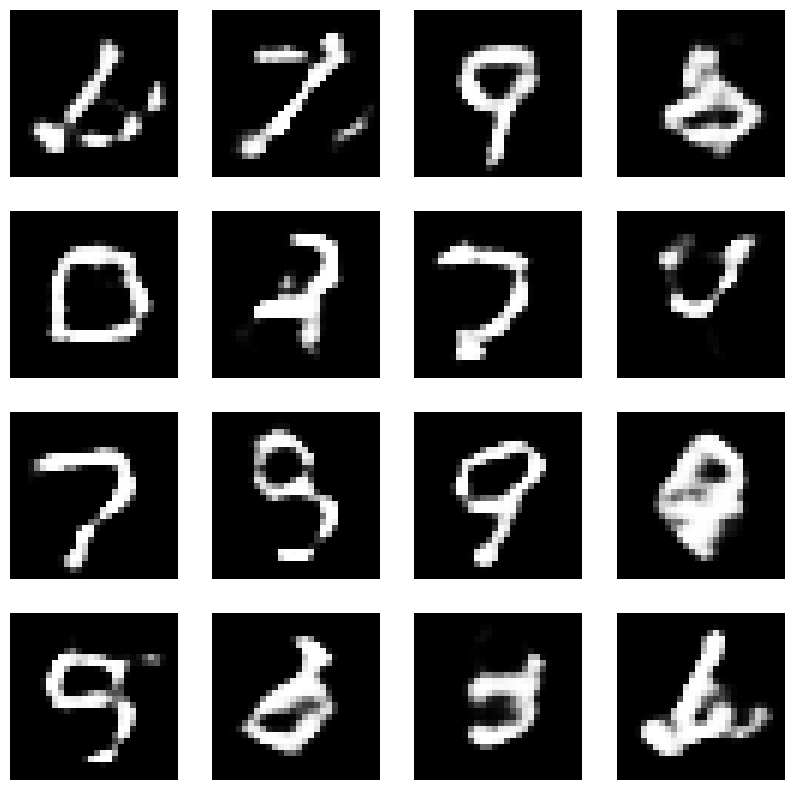

Epoch:  41


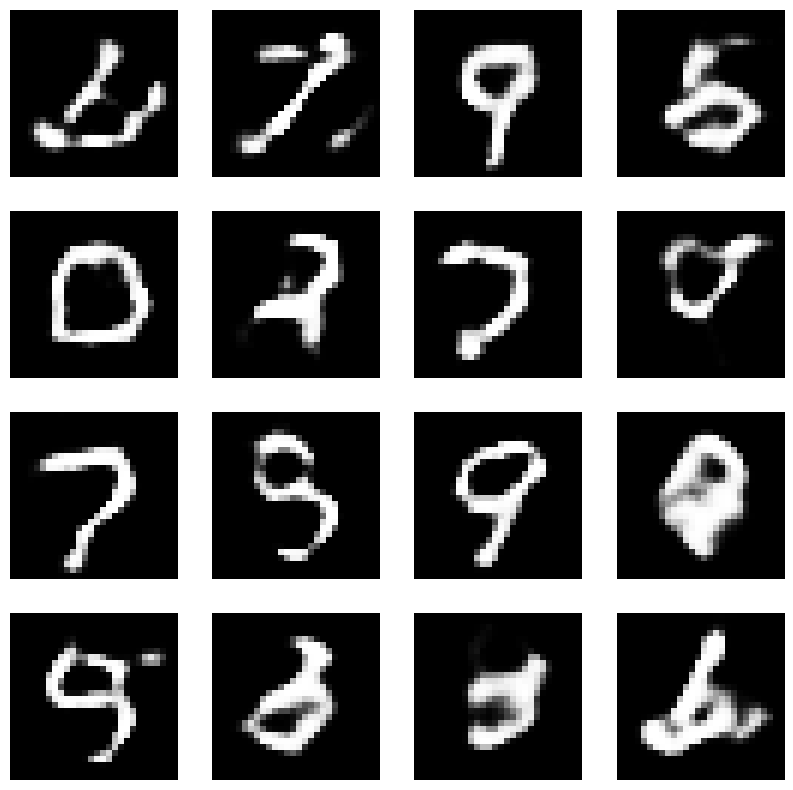

Epoch:  42


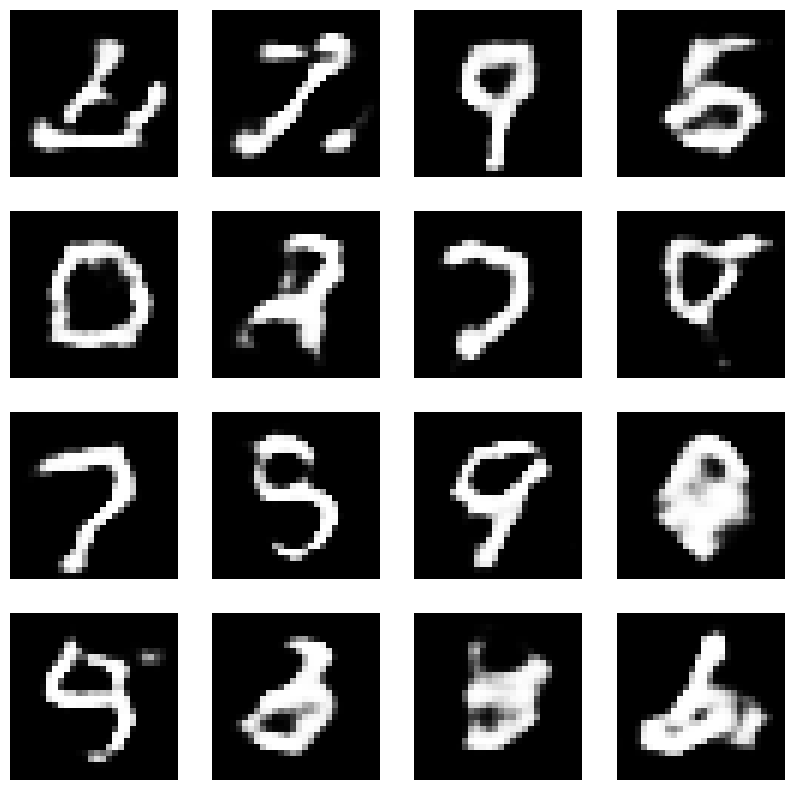

Epoch:  43


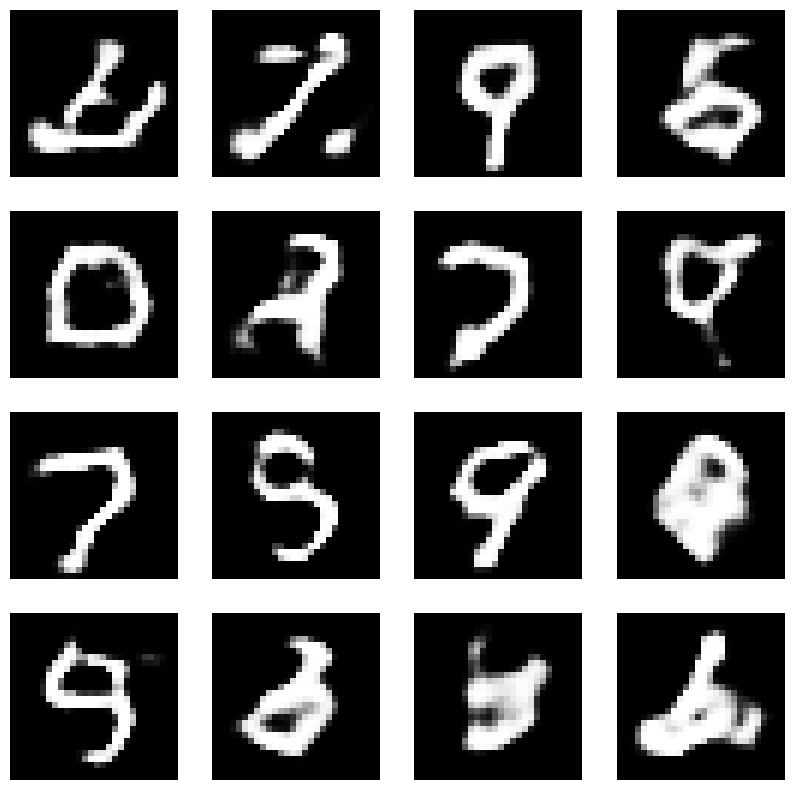

Epoch:  44


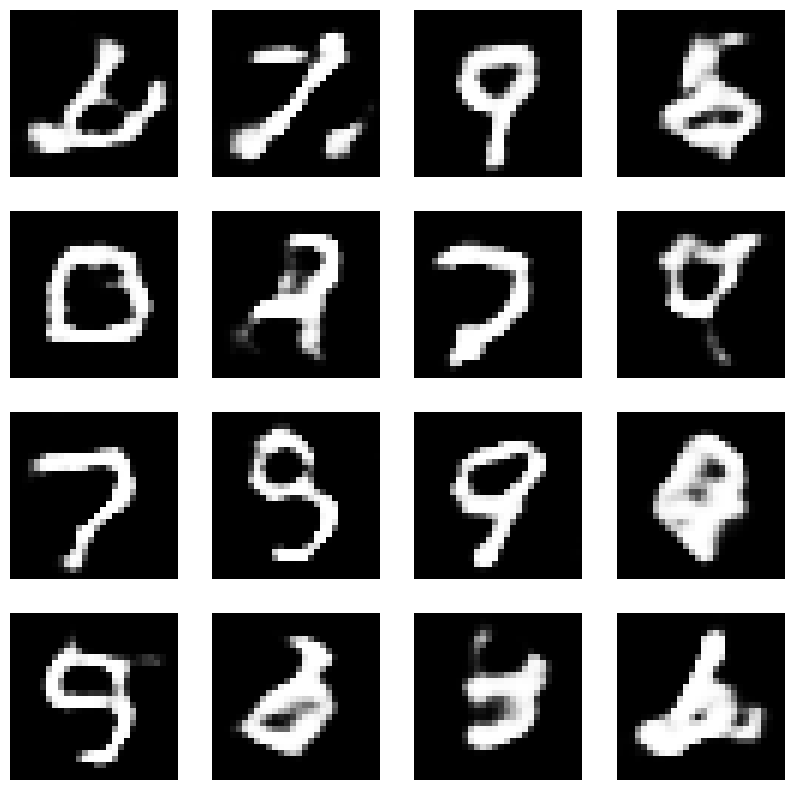

Epoch:  45


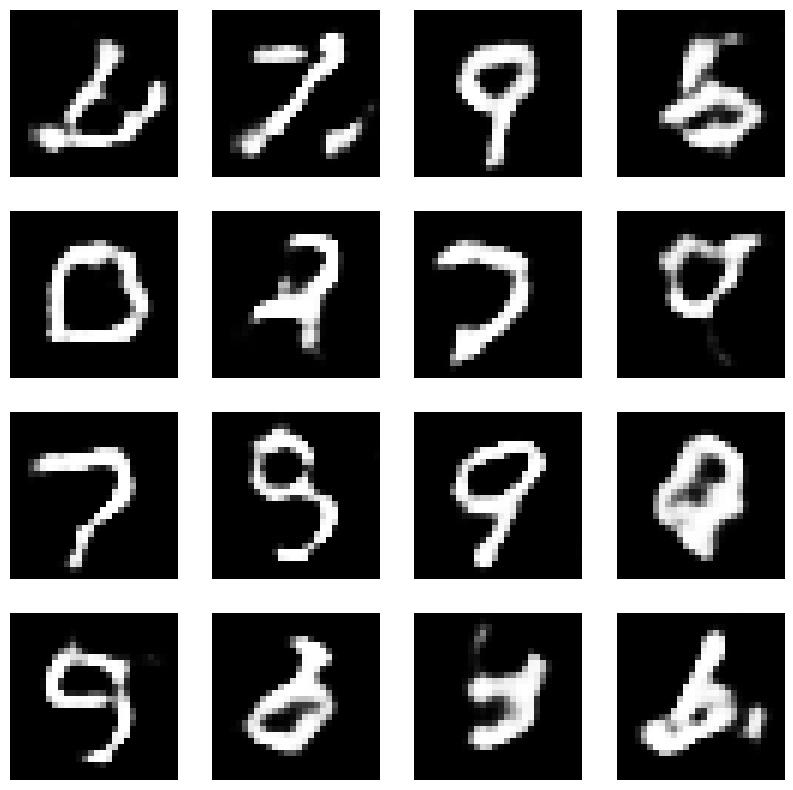

Epoch:  46


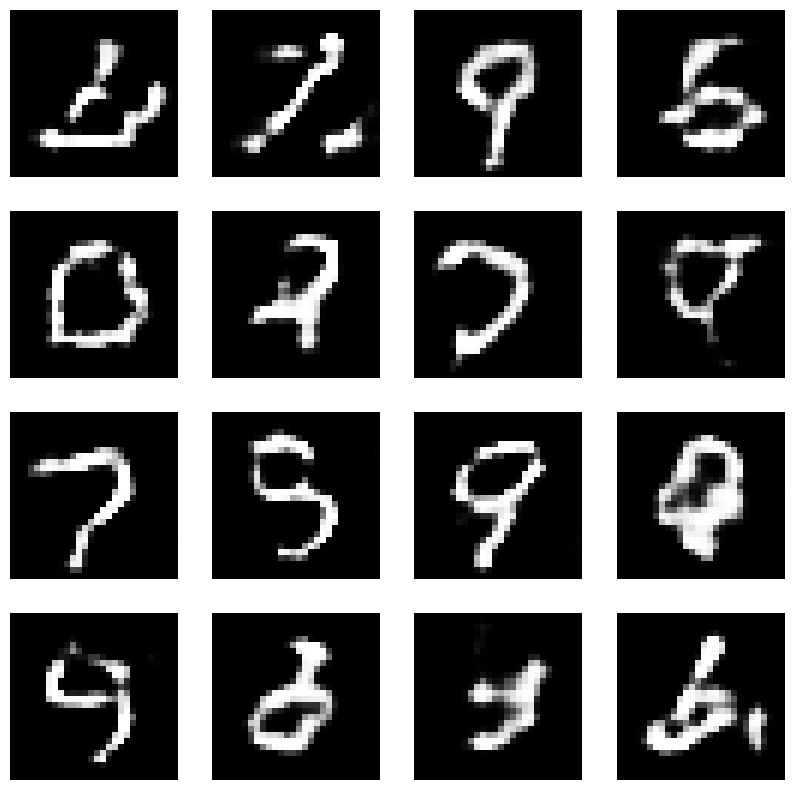

Epoch:  47


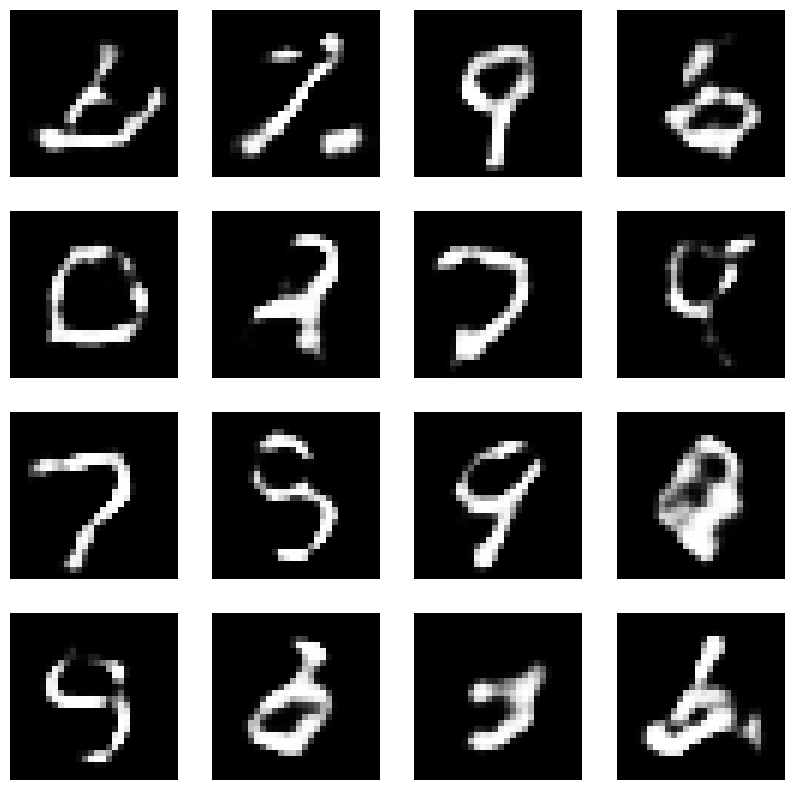

Epoch:  48


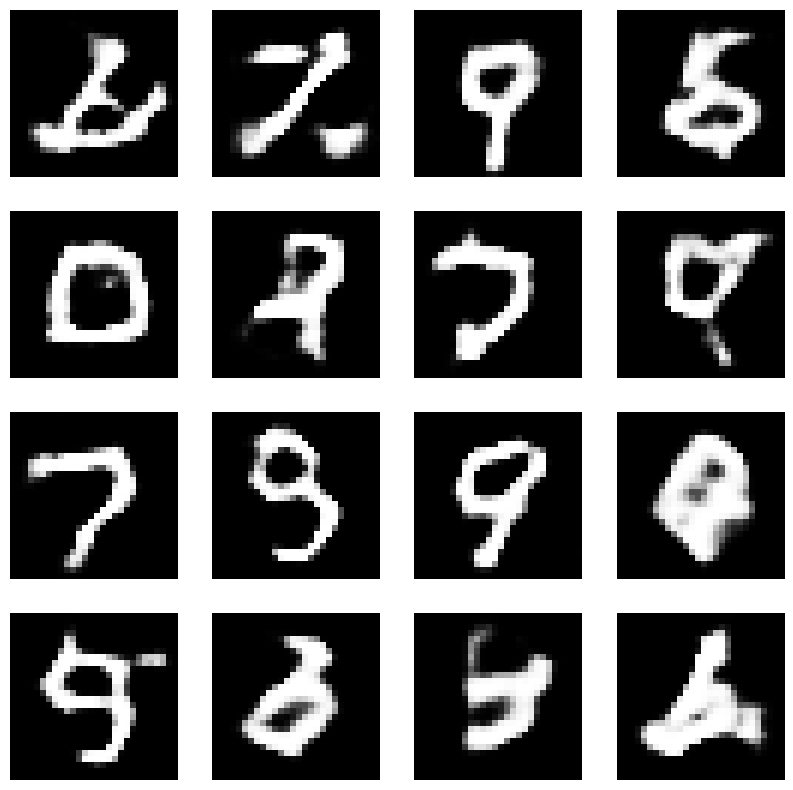

Epoch:  49


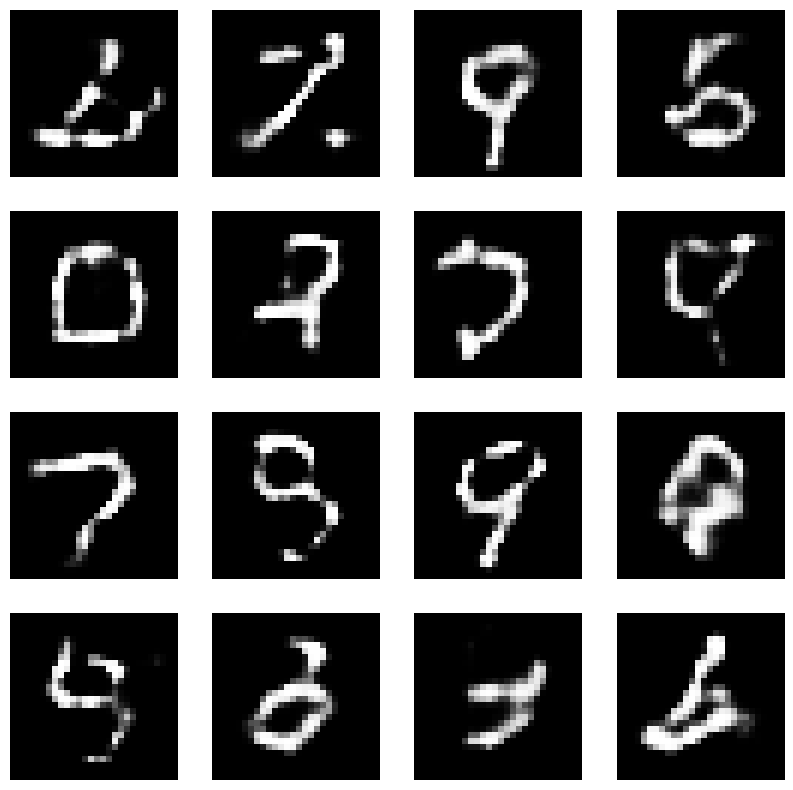

Epoch:  50


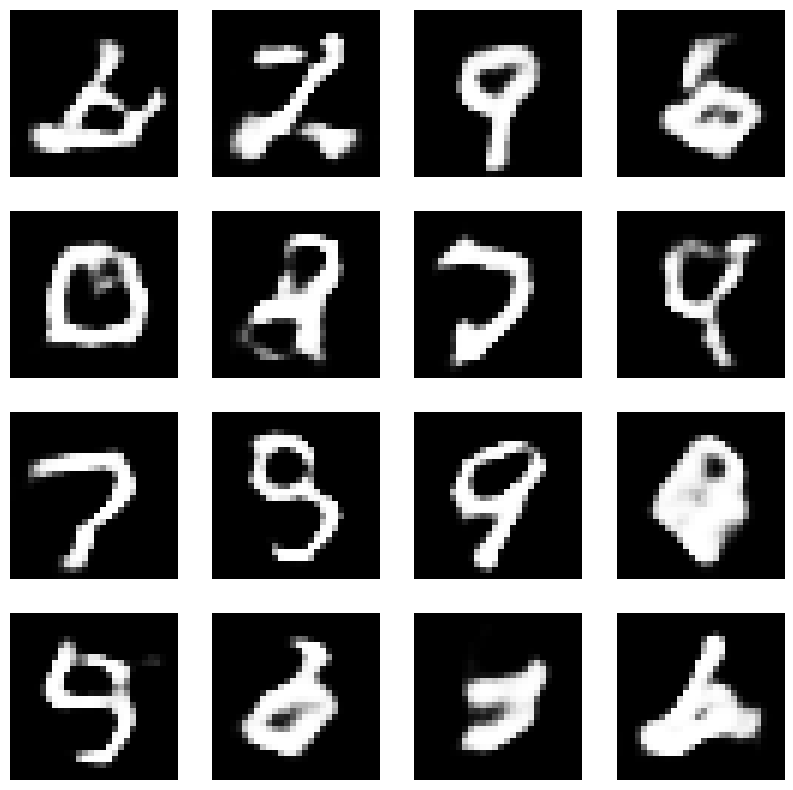

Epoch:  51


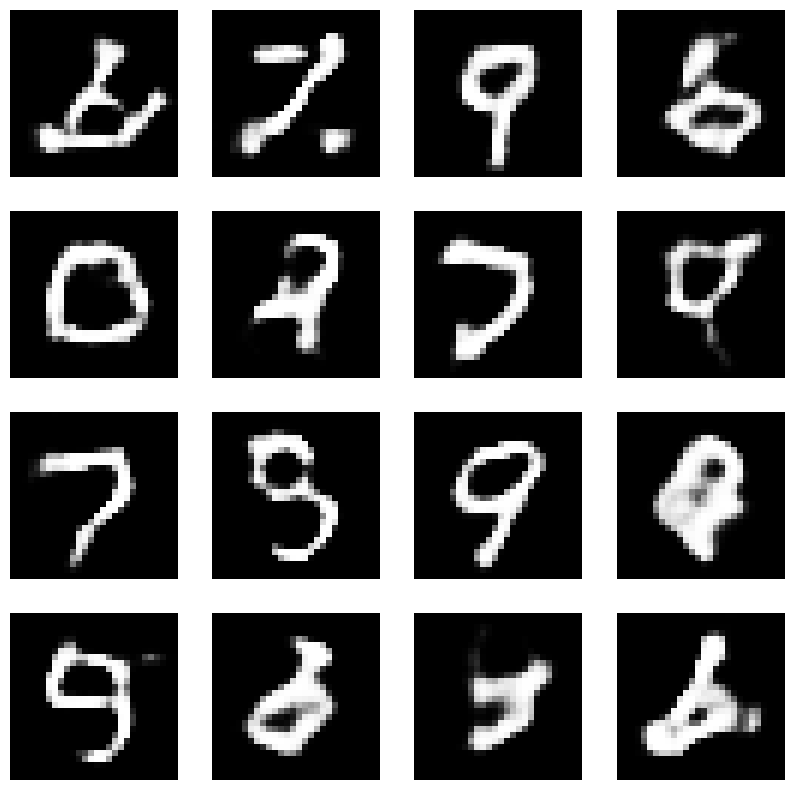

Epoch:  52


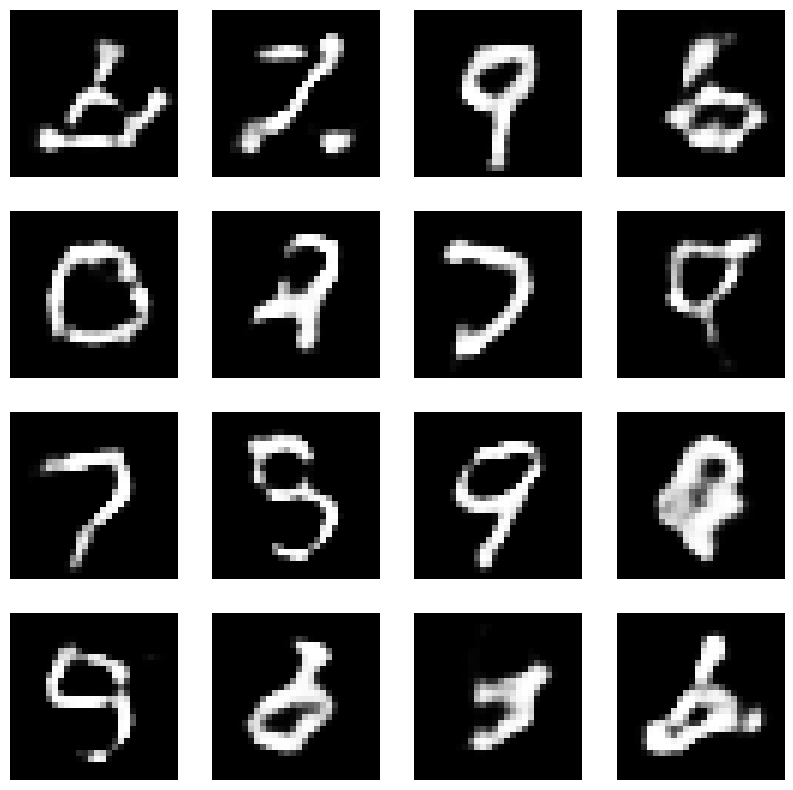

Epoch:  53


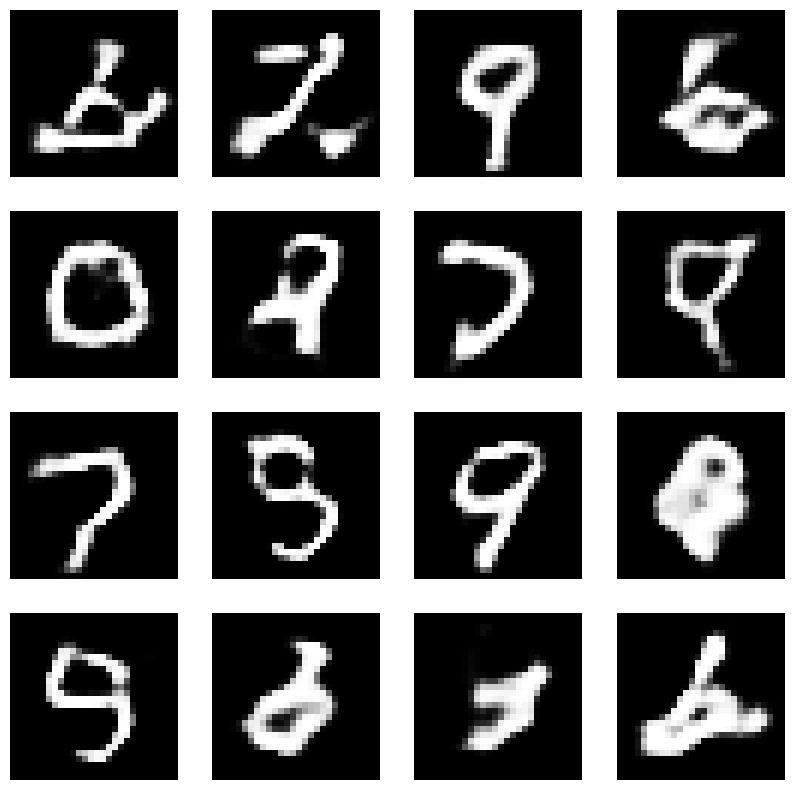

Epoch:  54


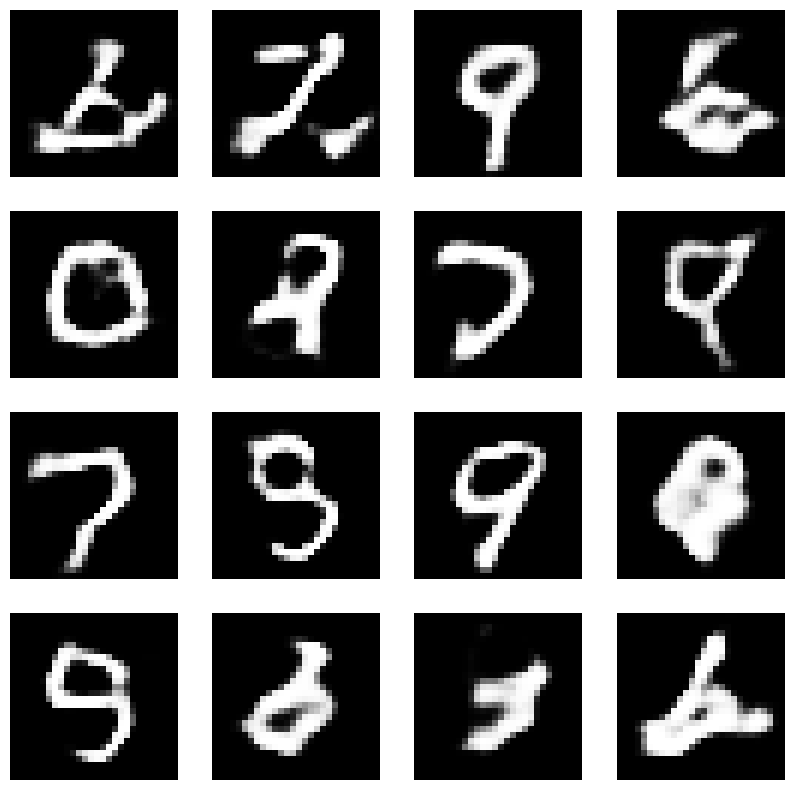

Epoch:  55


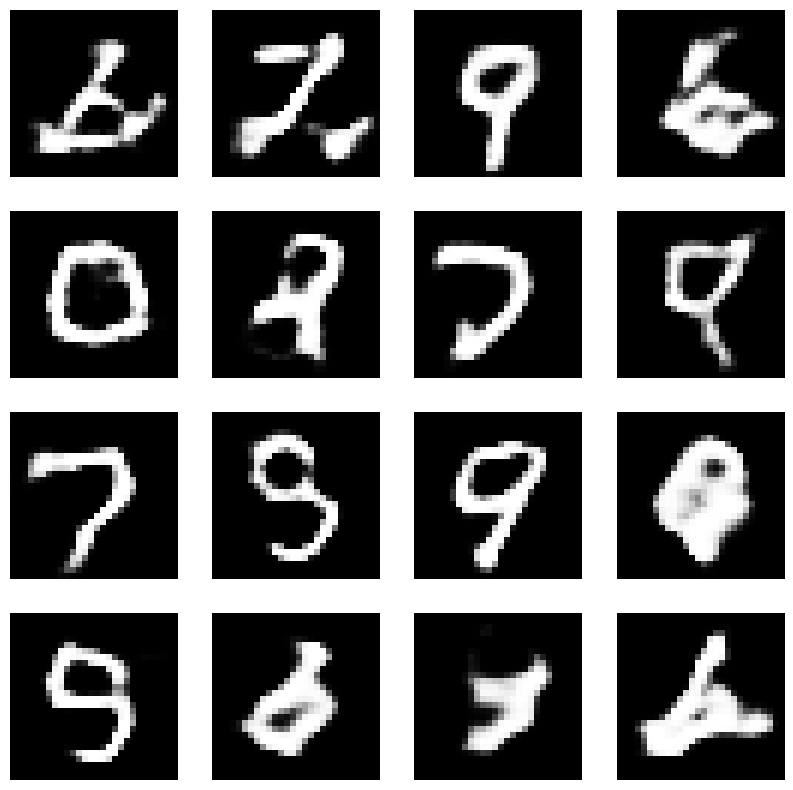

Epoch:  56


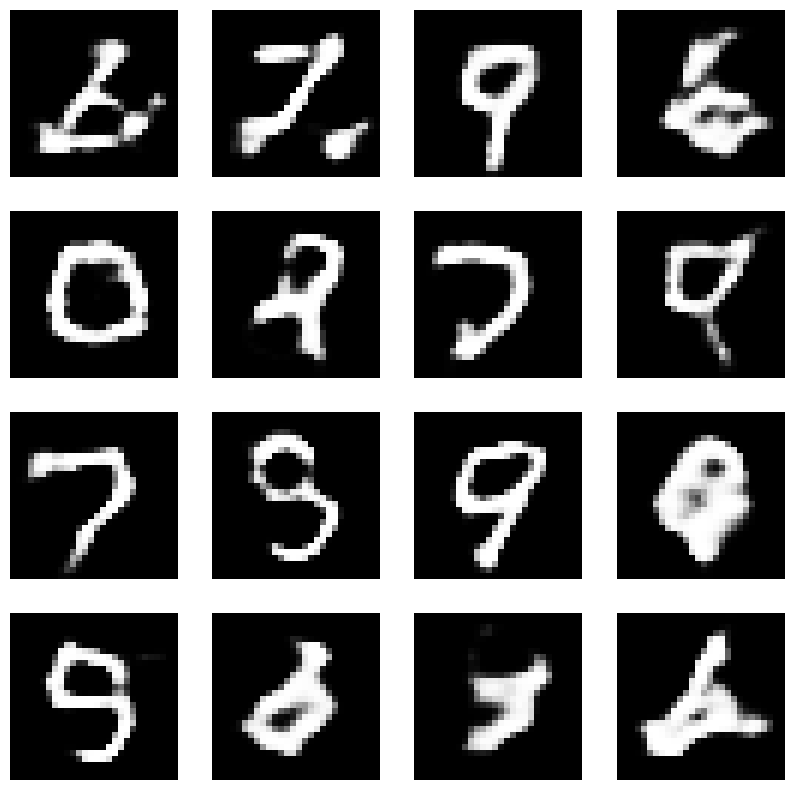

Epoch:  57


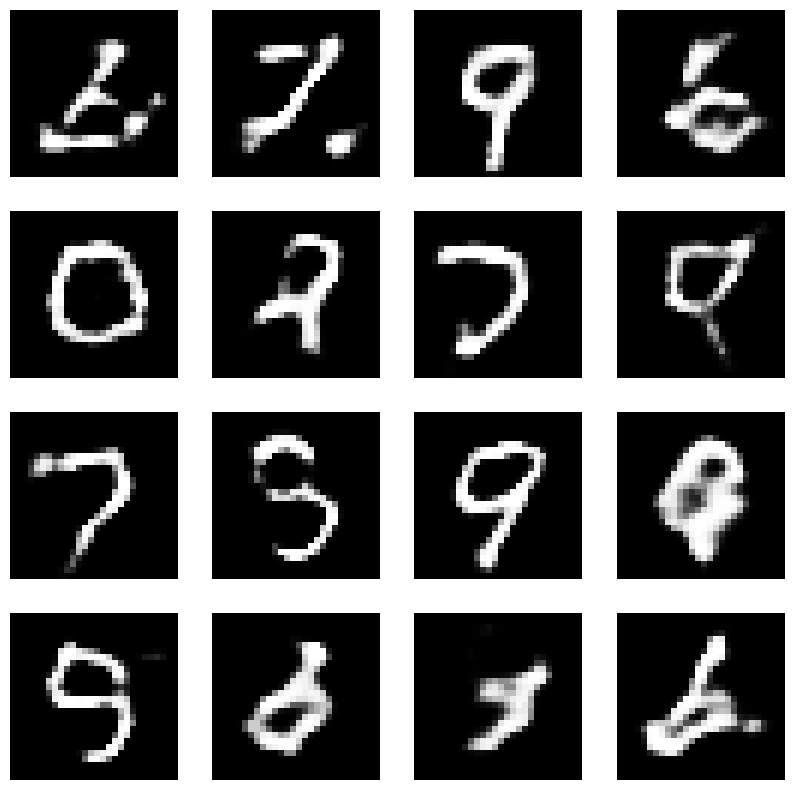

Epoch:  58


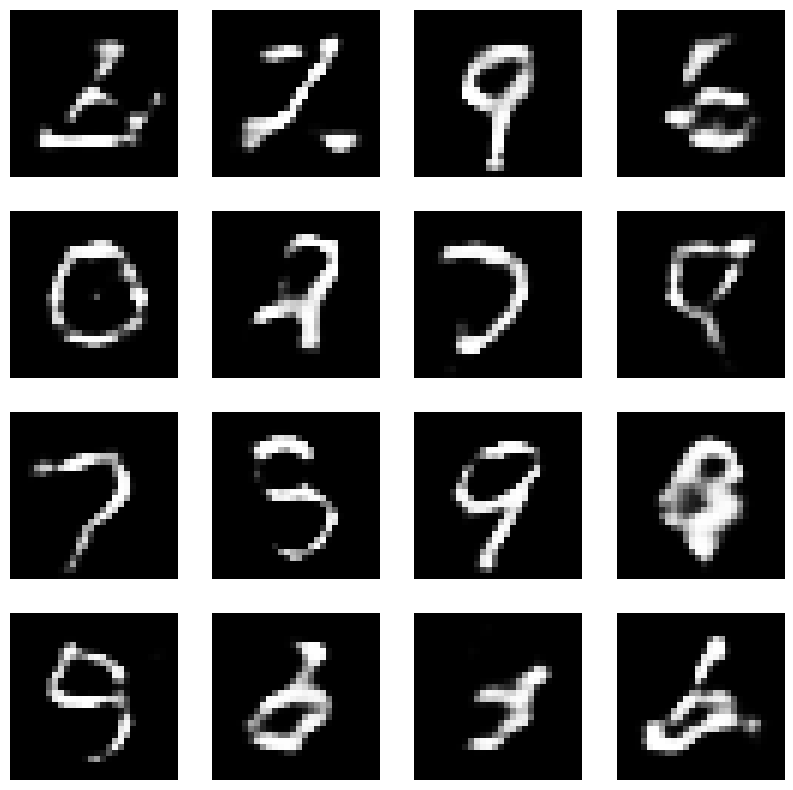

Epoch:  59


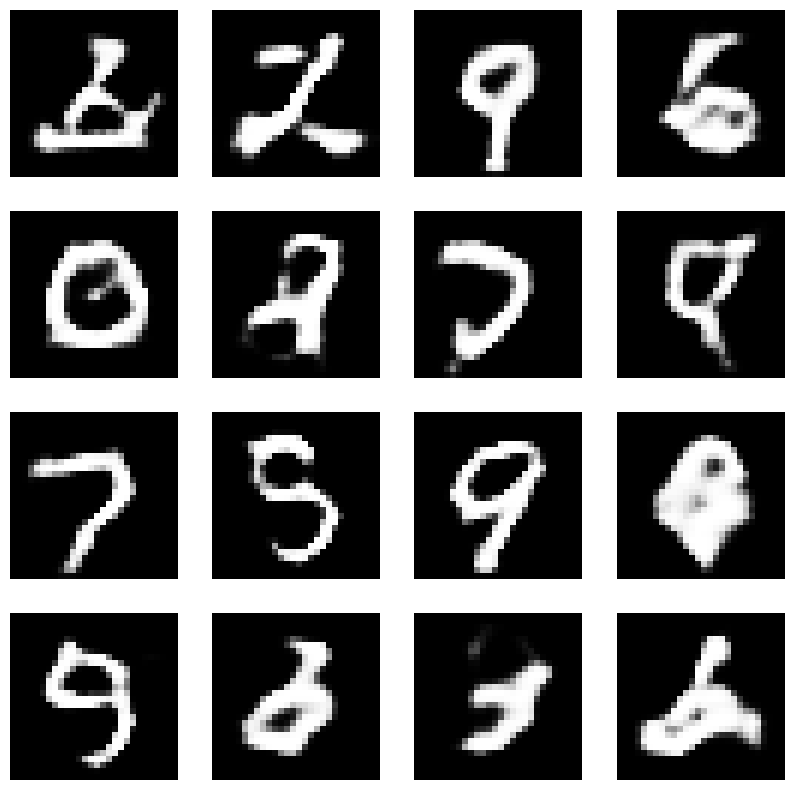

Epoch:  60


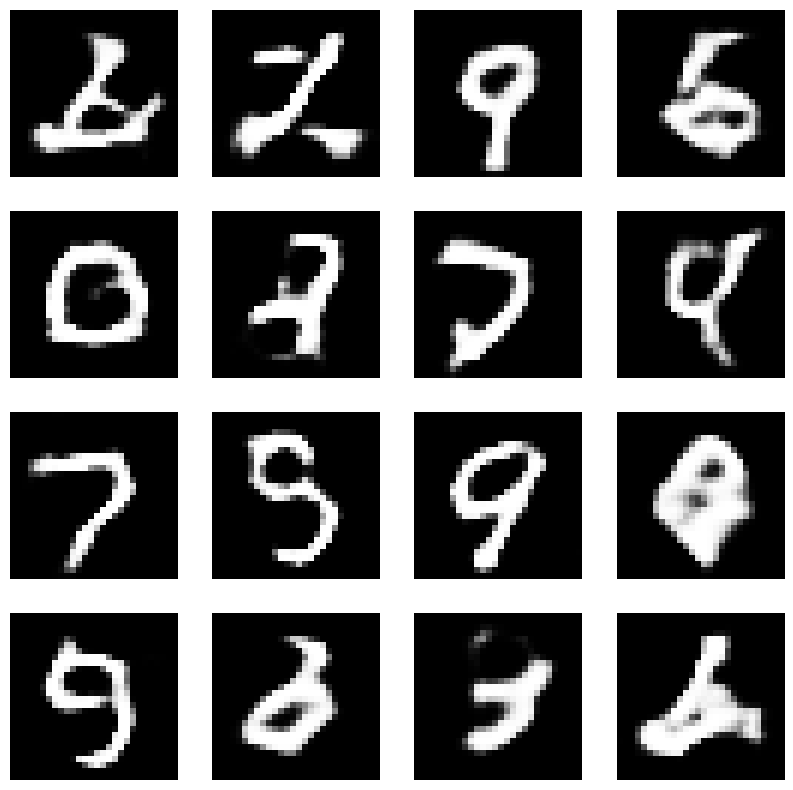

Epoch:  61


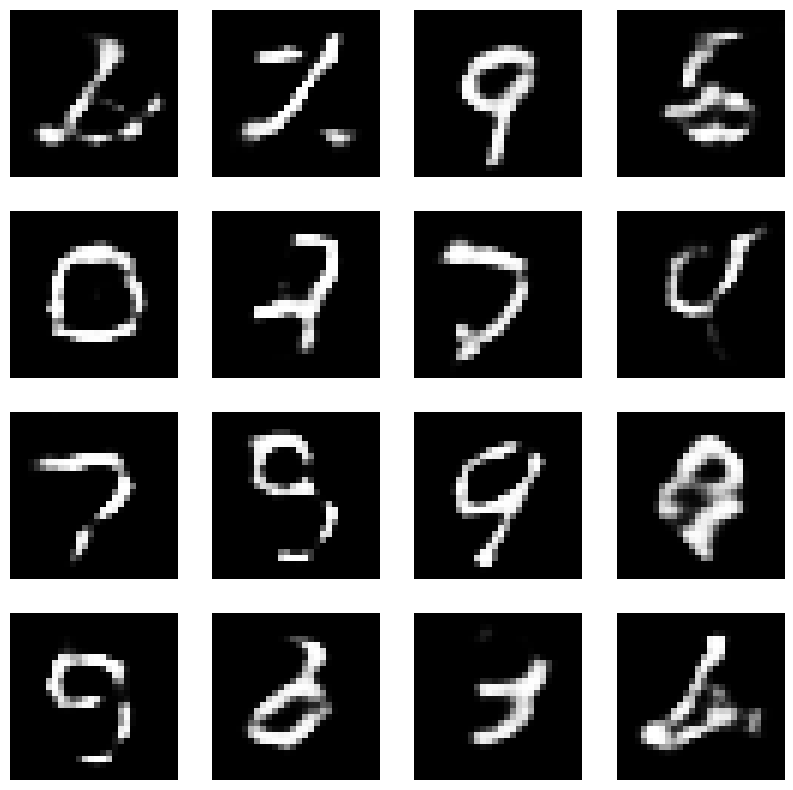

Epoch:  62


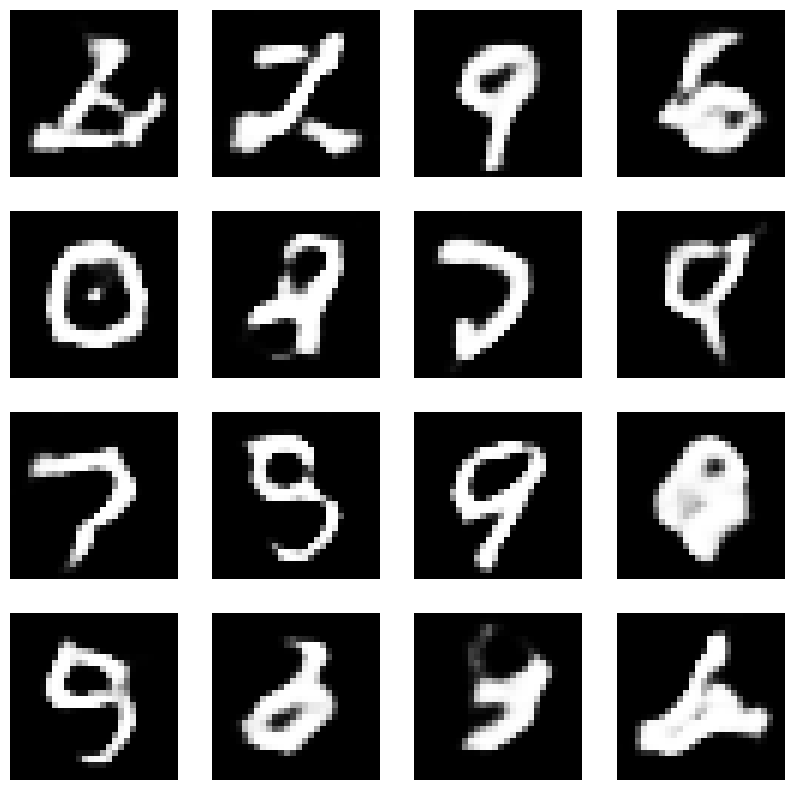

Epoch:  63


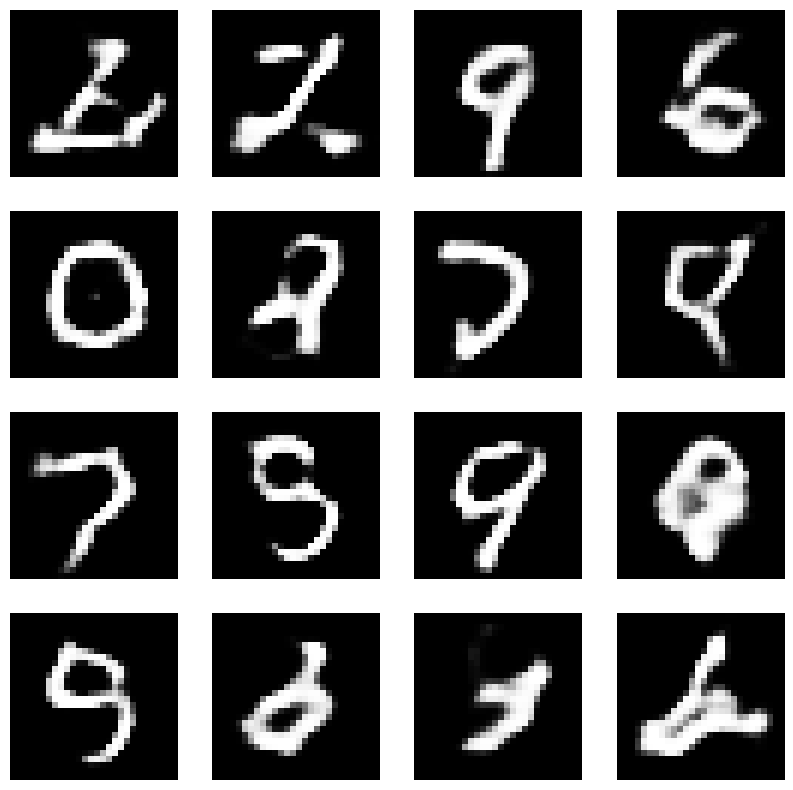

Epoch:  64


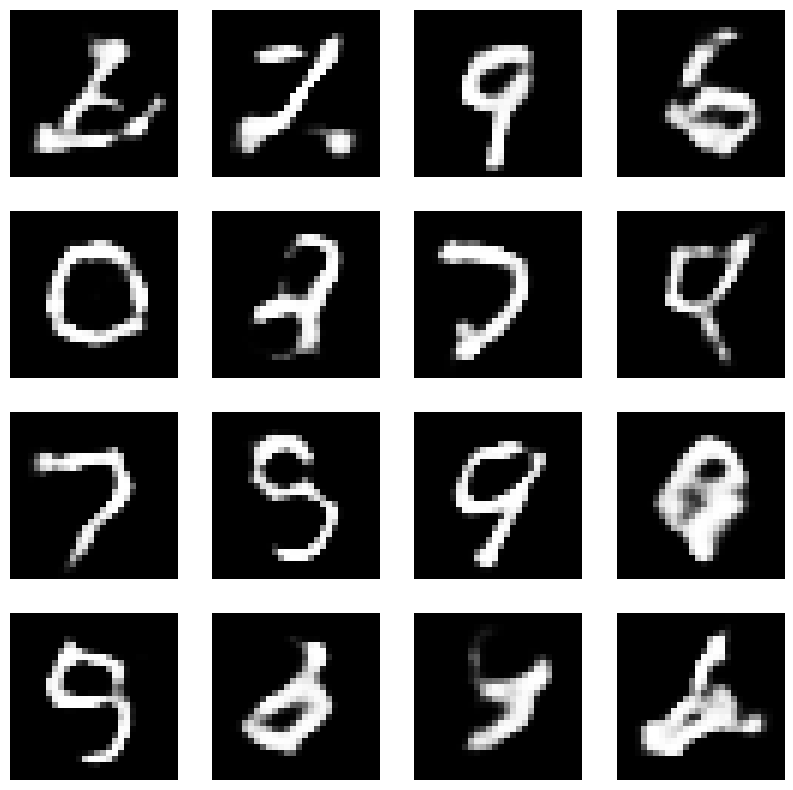

Epoch:  65


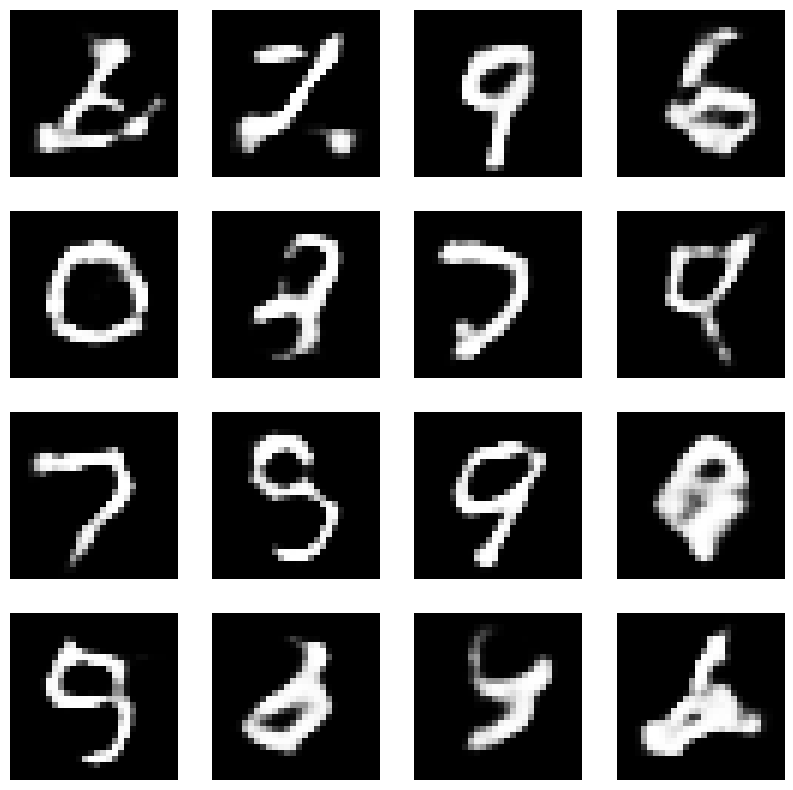

Epoch:  66


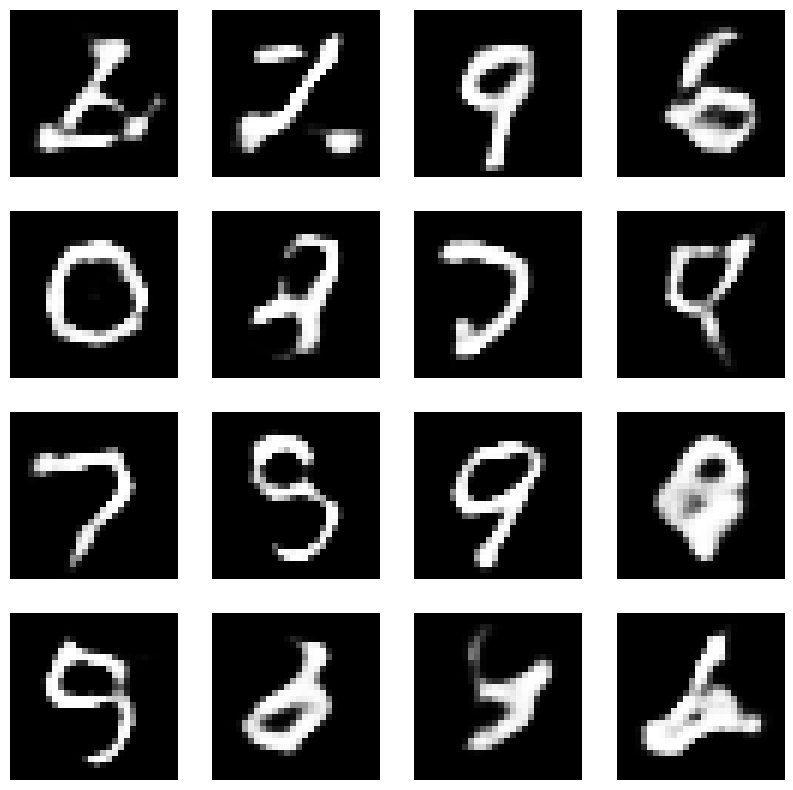

Epoch:  67


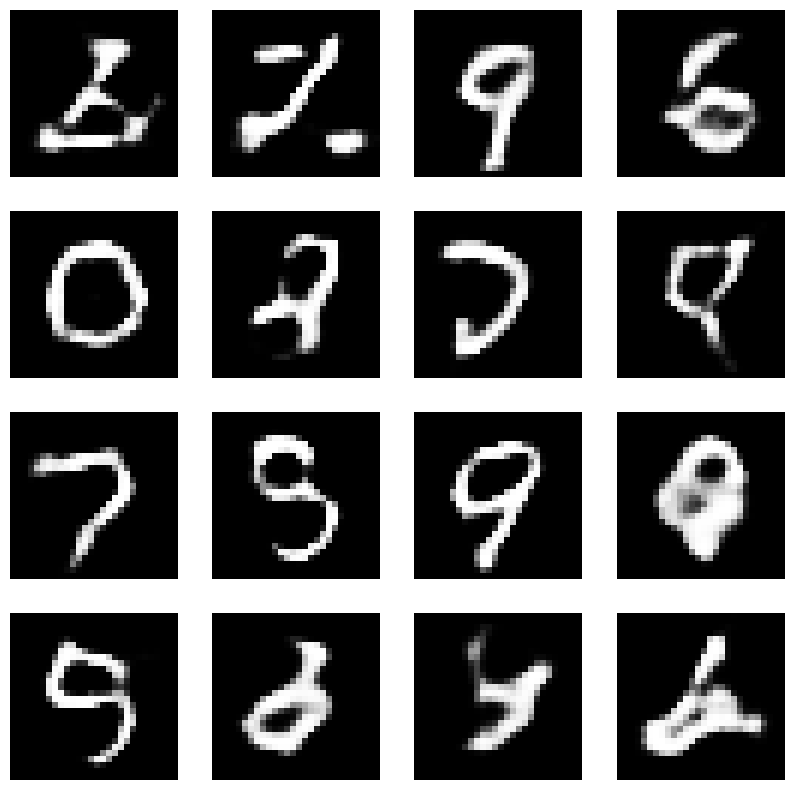

Epoch:  68


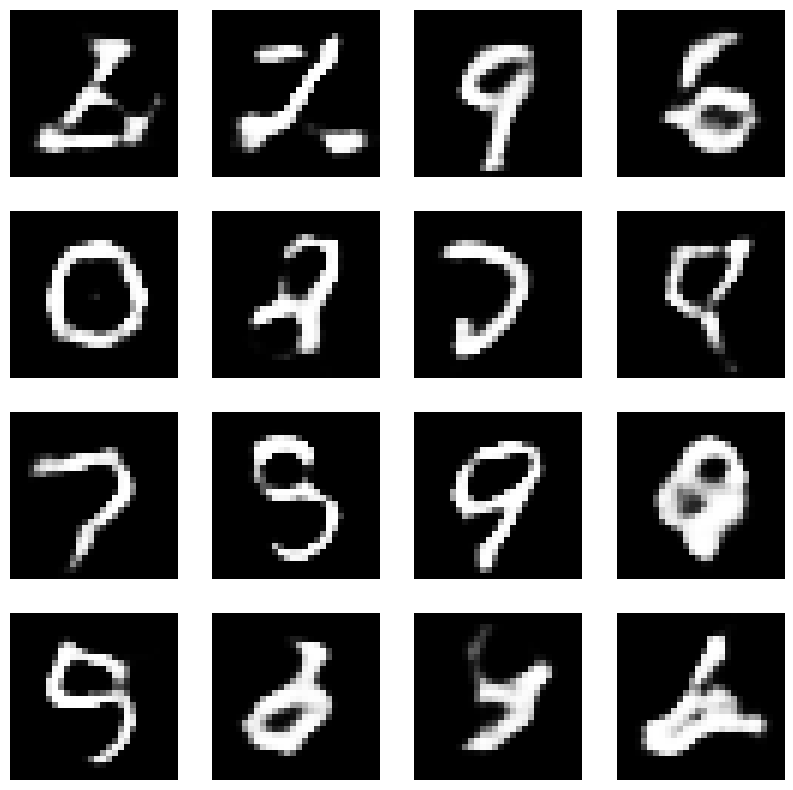

Epoch:  69


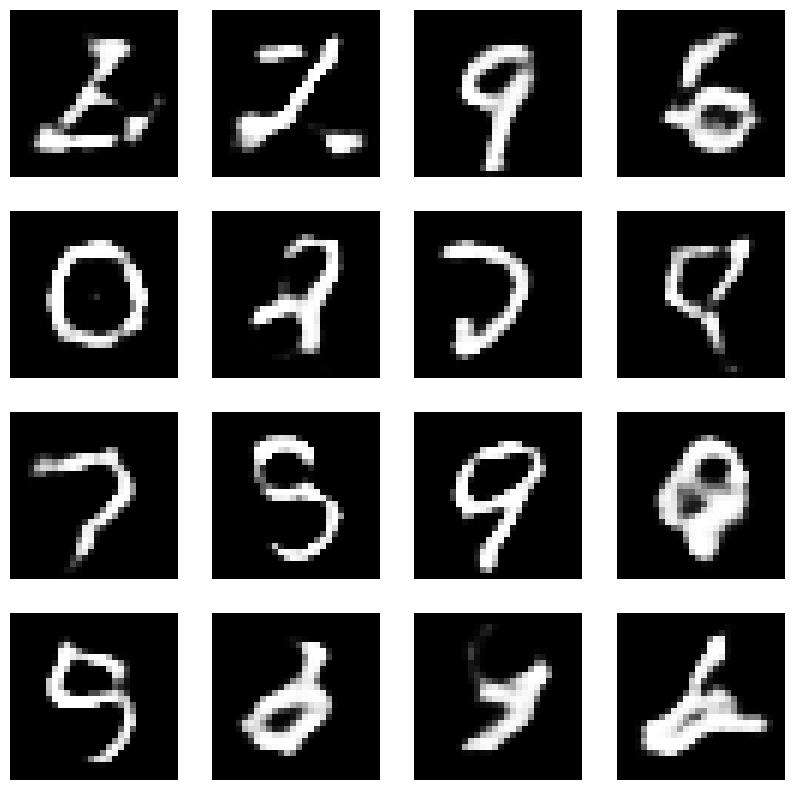

Epoch:  70


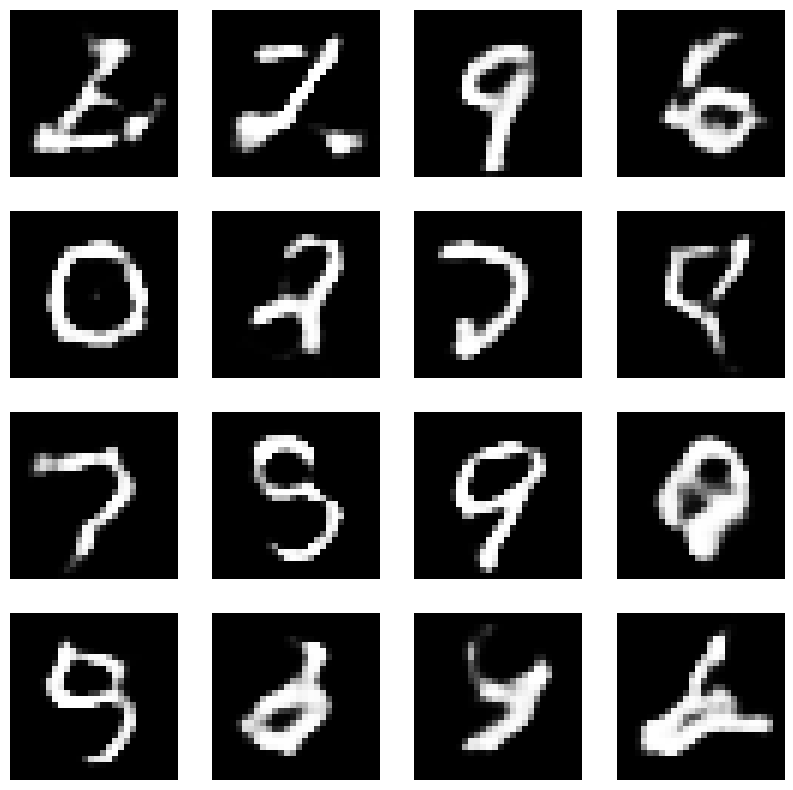

Epoch:  71


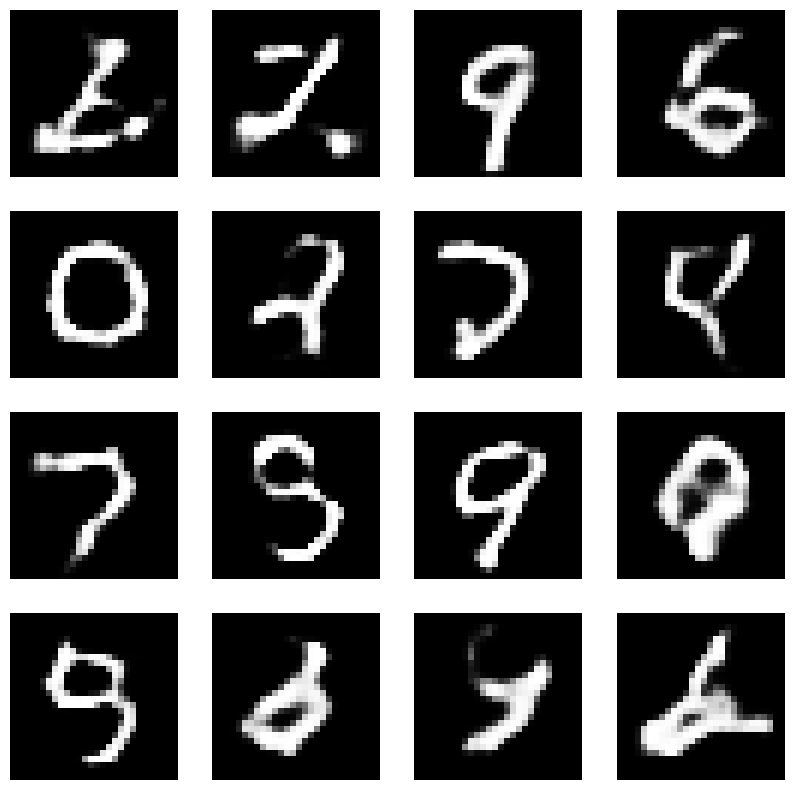

Epoch:  72


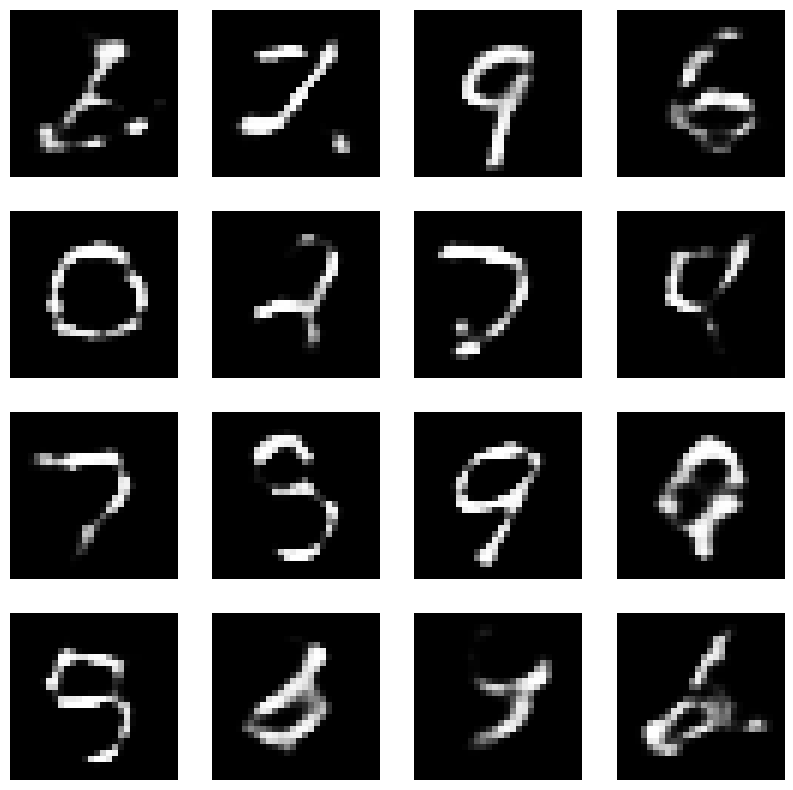

Epoch:  73


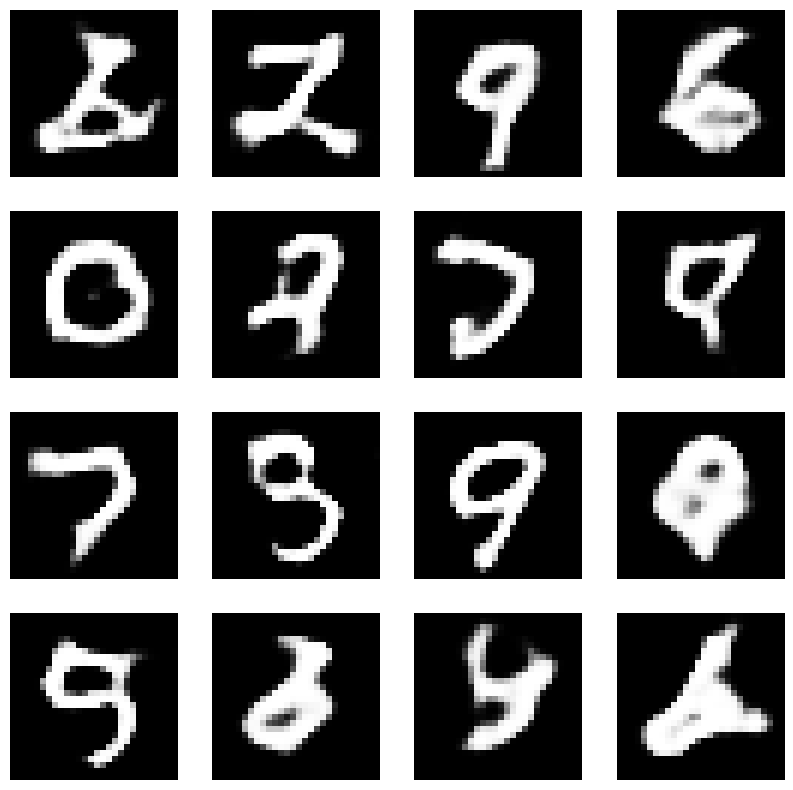

Epoch:  74


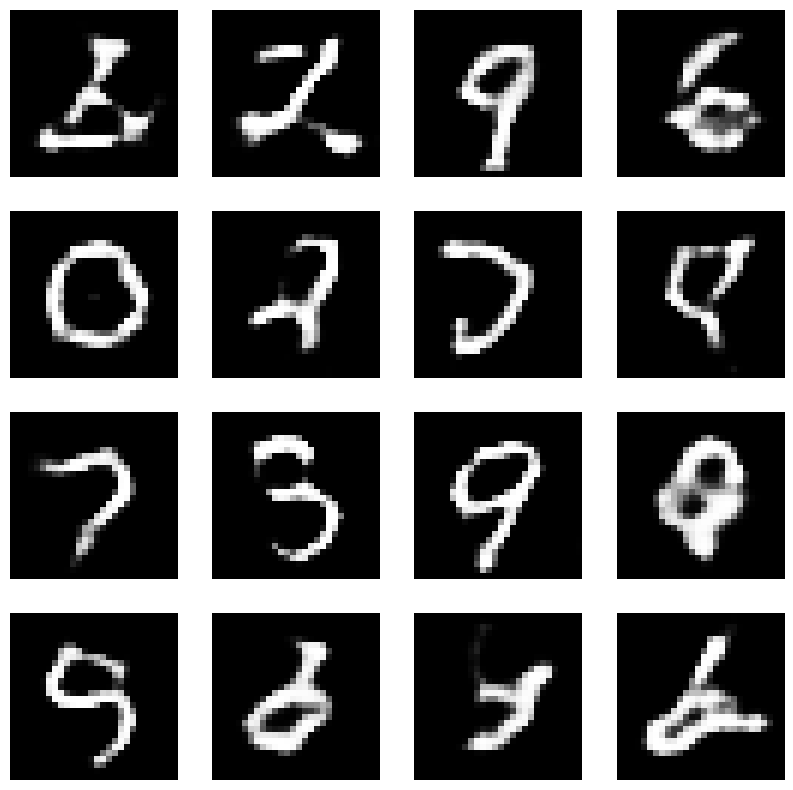

Epoch:  75


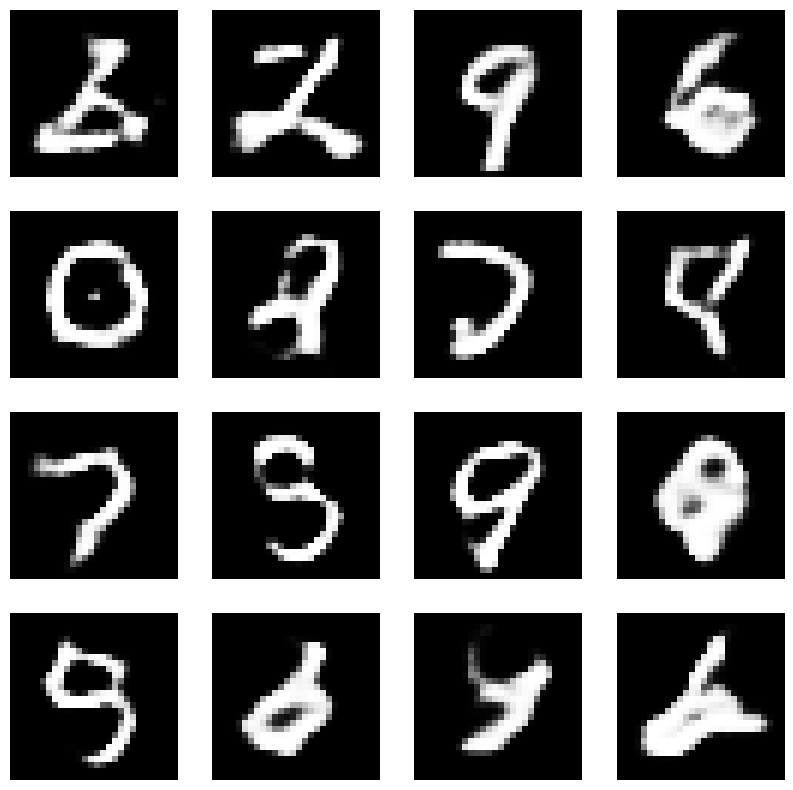

Epoch:  76


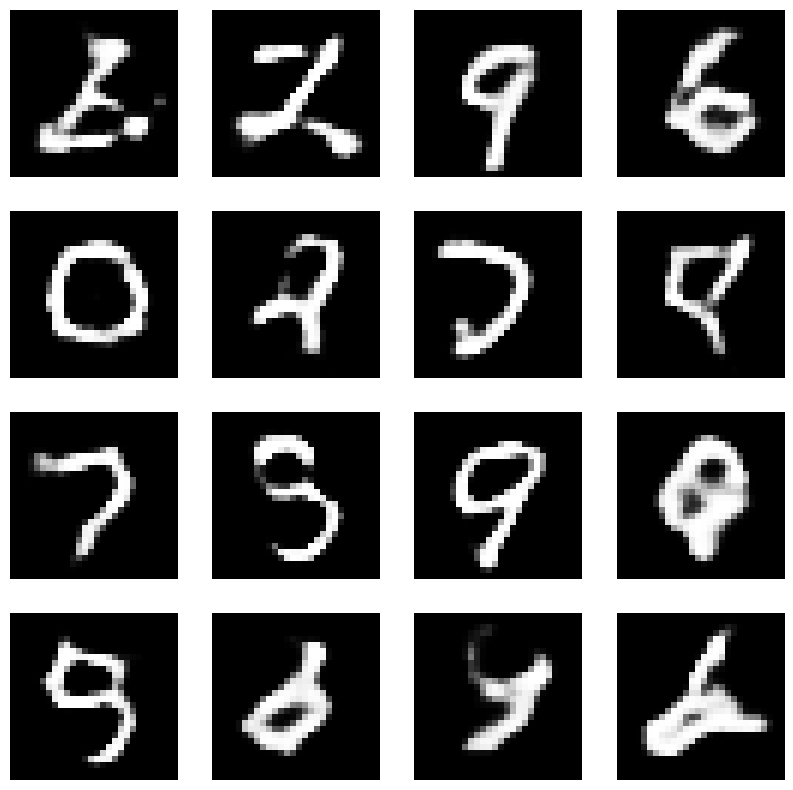

Epoch:  77


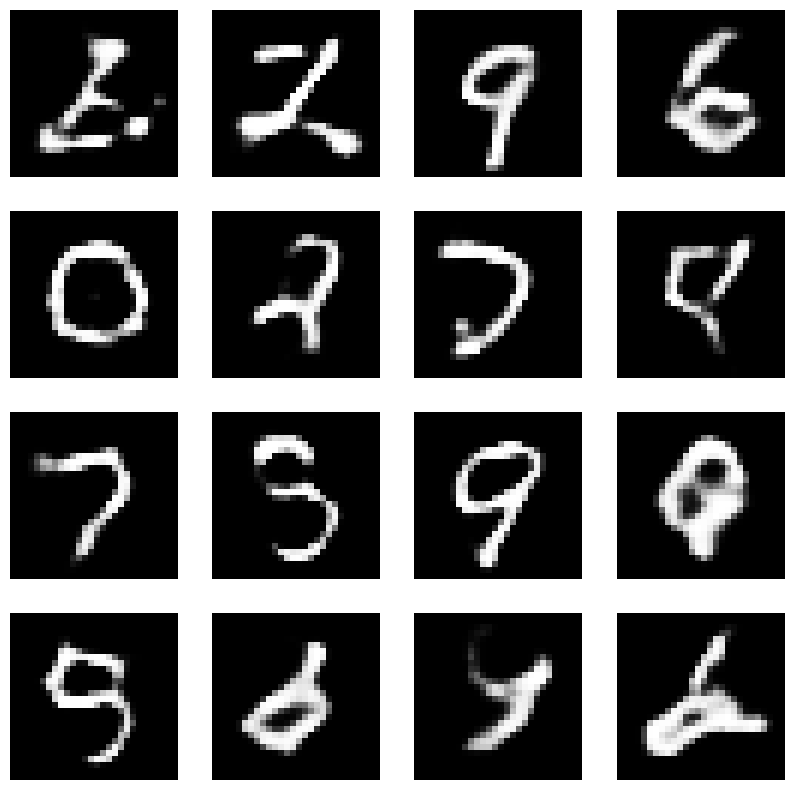

Epoch:  78


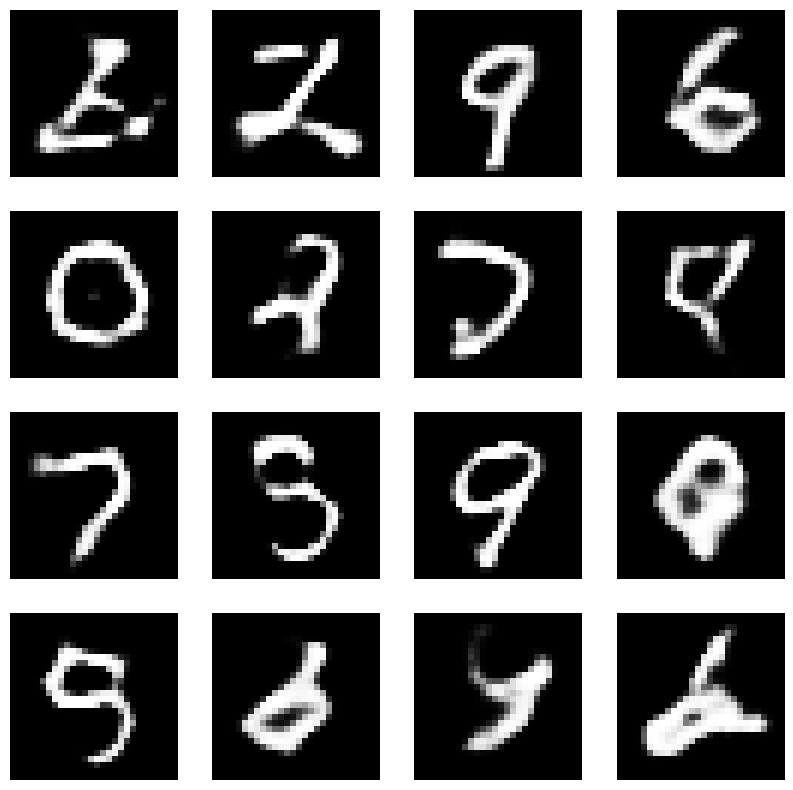

Epoch:  79


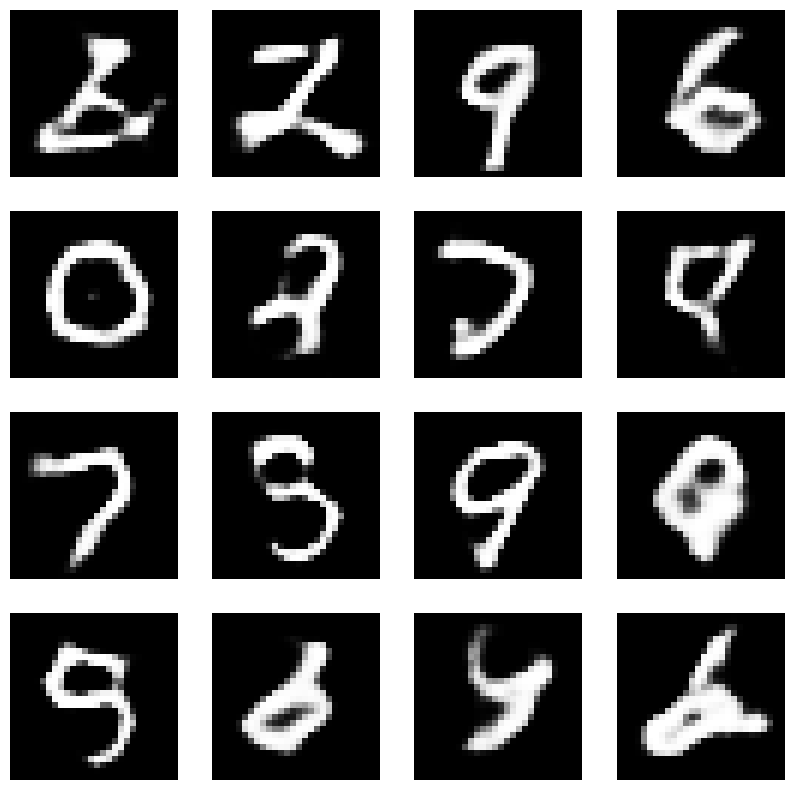

Epoch:  80


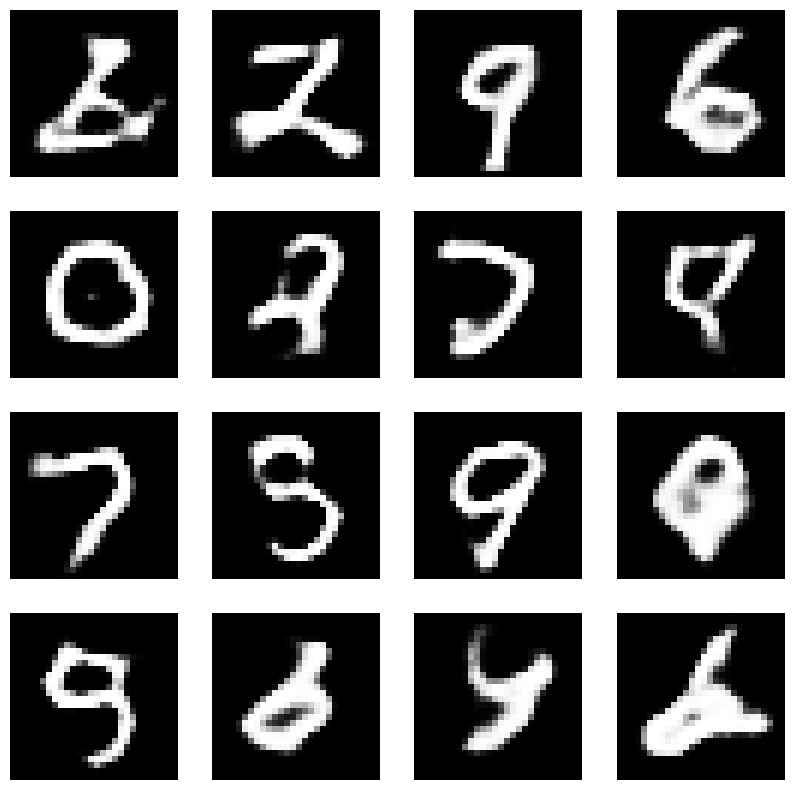

Epoch:  81


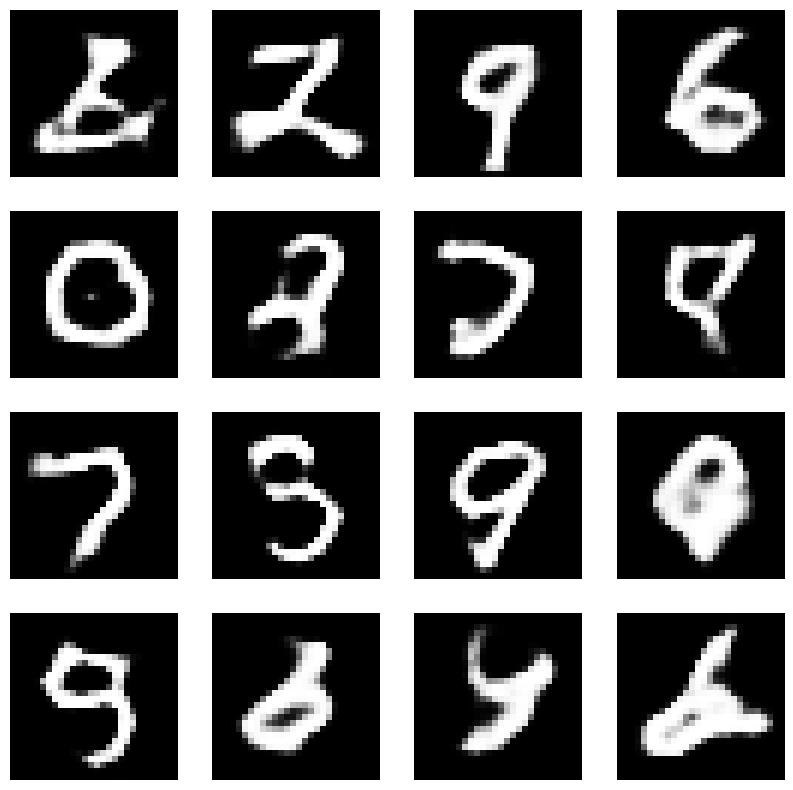

Epoch:  82


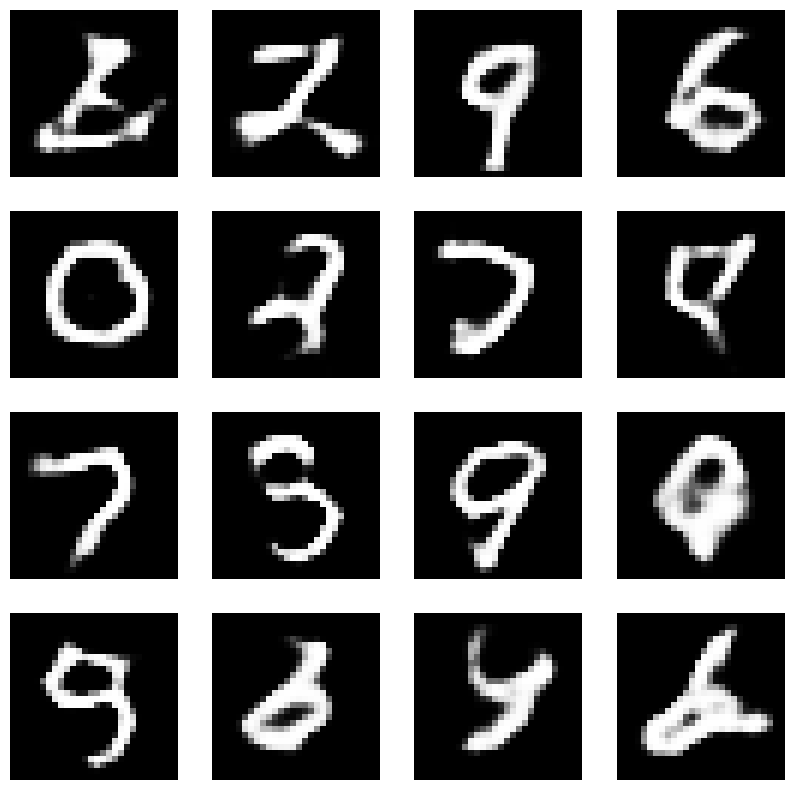

Epoch:  83


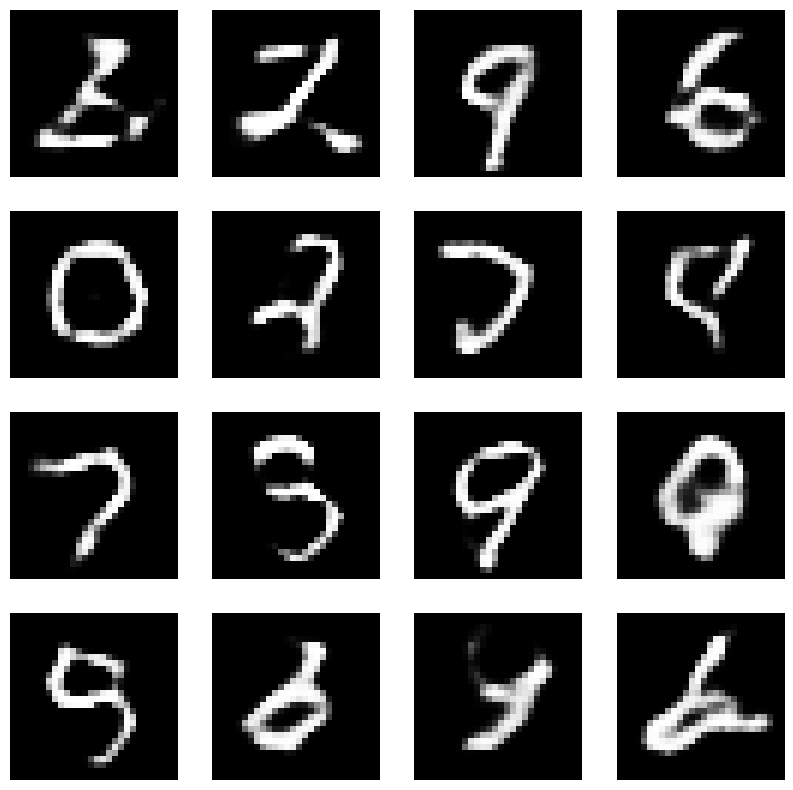

Epoch:  84


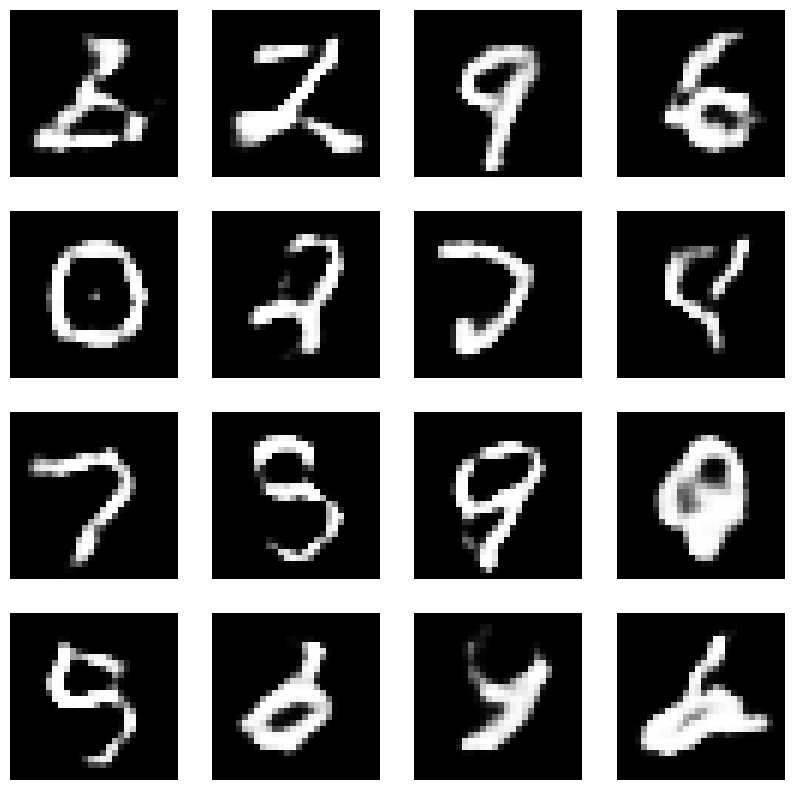

Epoch:  85


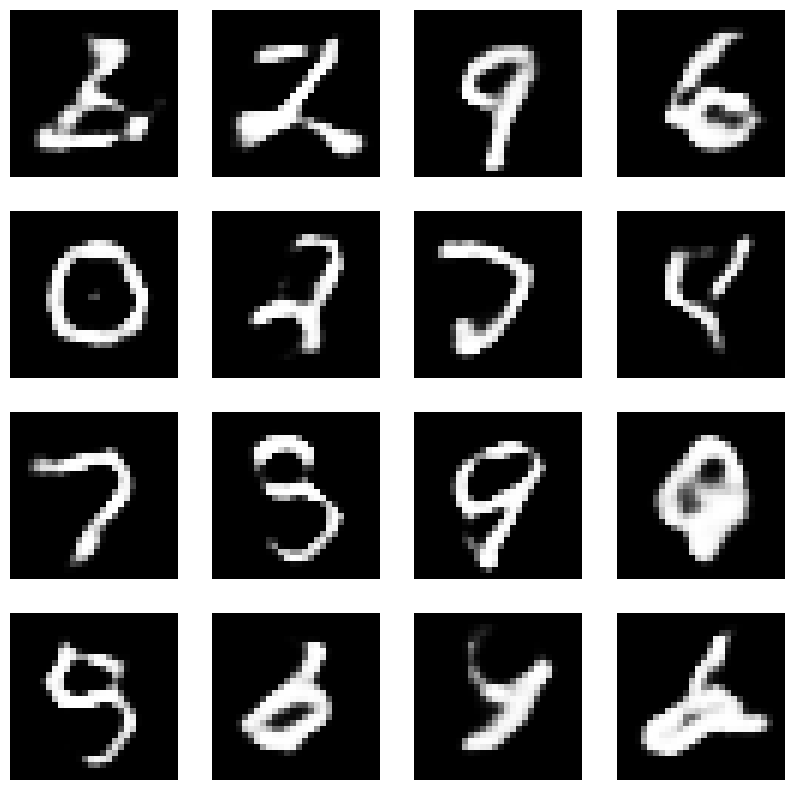

Epoch:  86


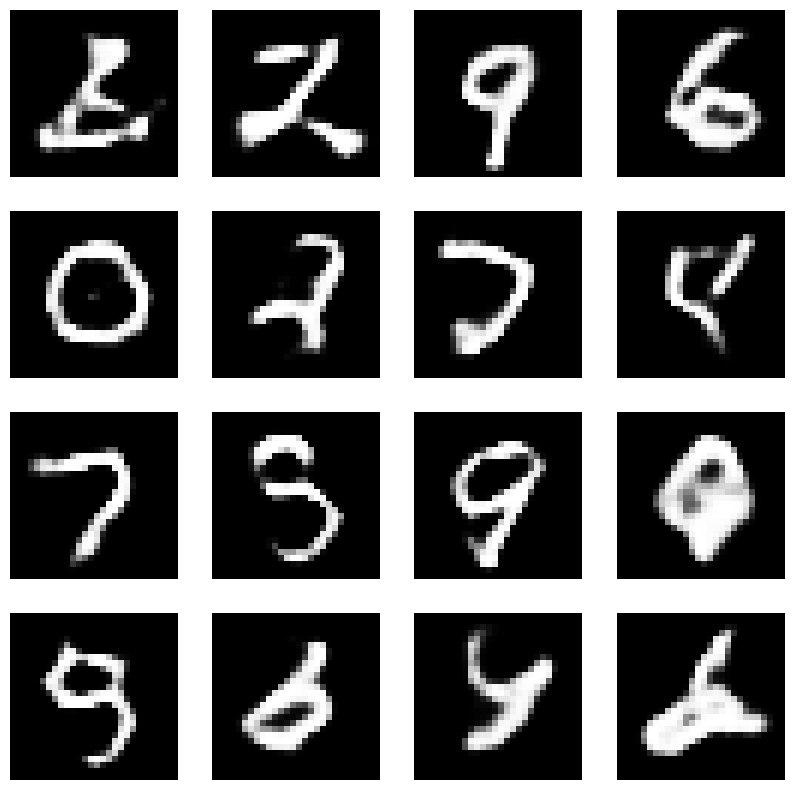

Epoch:  87


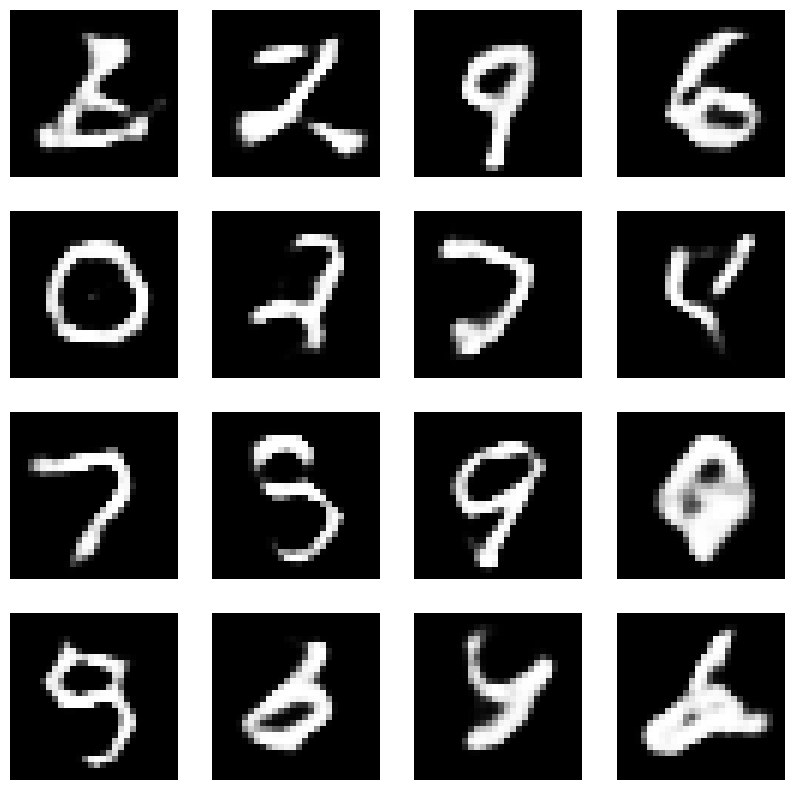

Epoch:  88


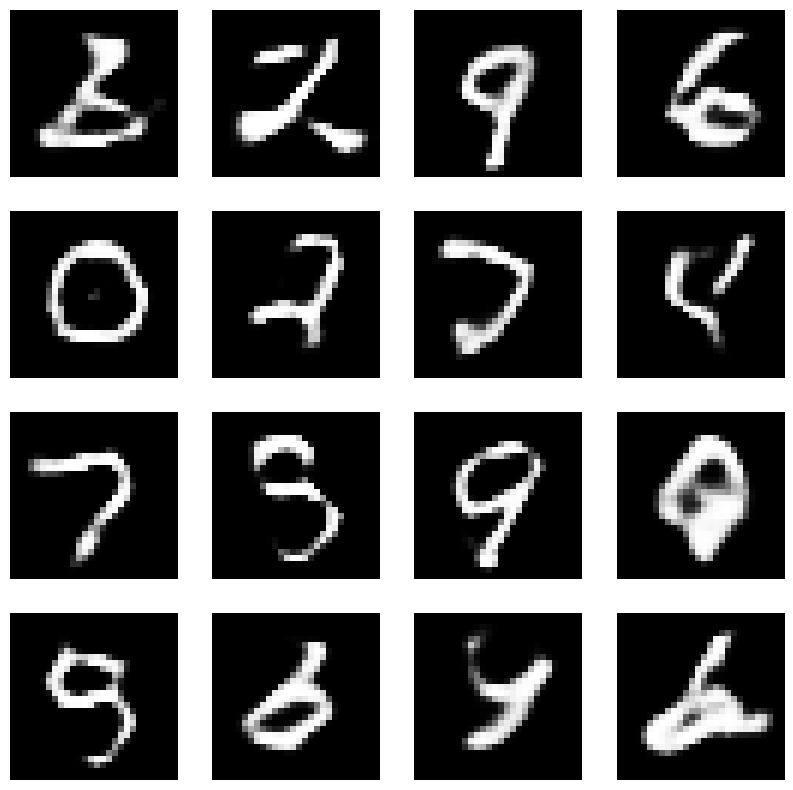

Epoch:  89


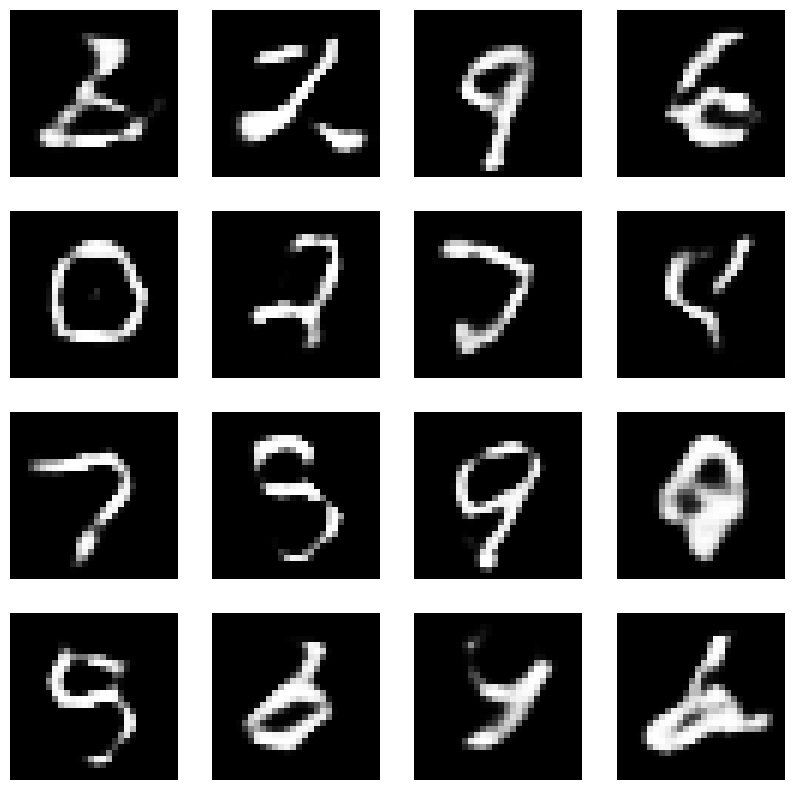

Epoch:  90


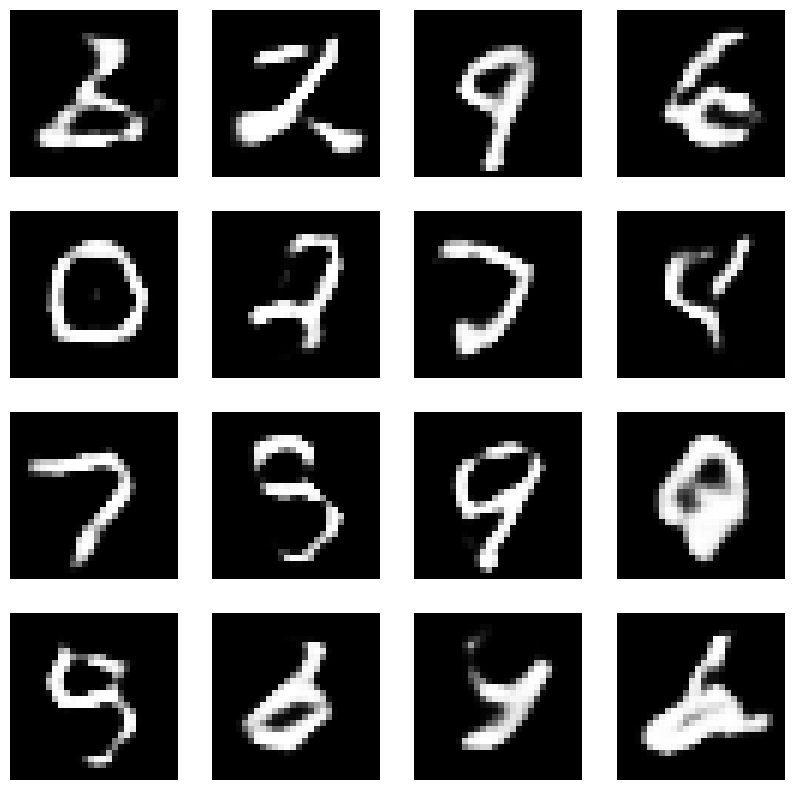

Epoch:  91


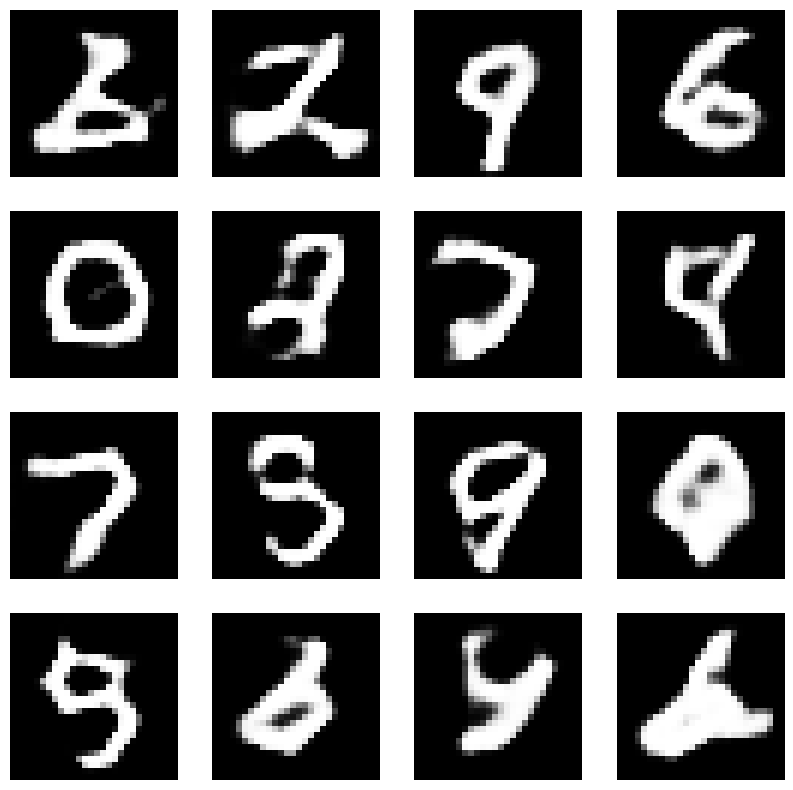

Epoch:  92


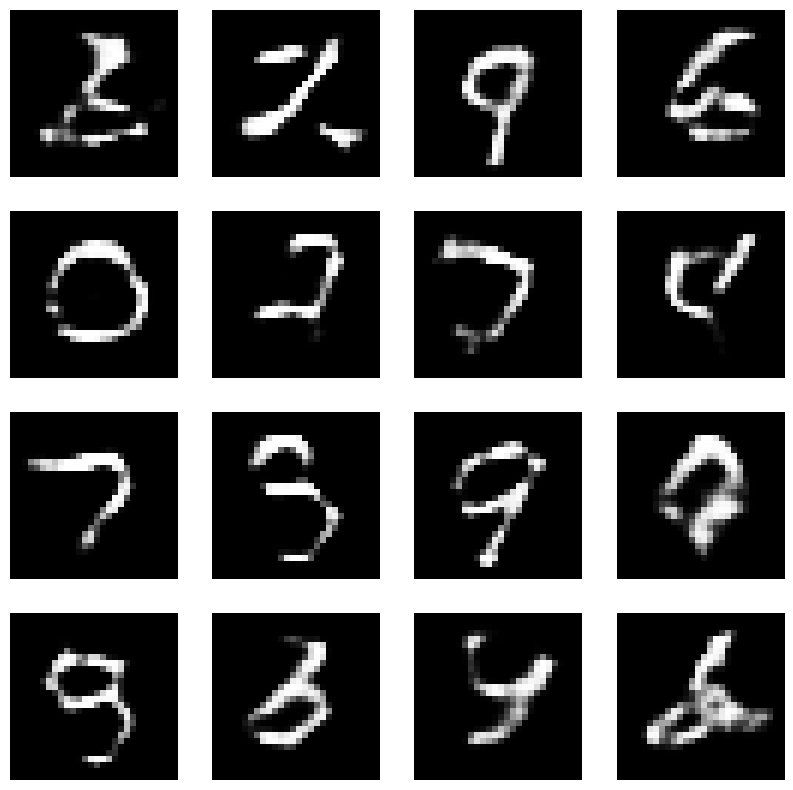

Epoch:  93


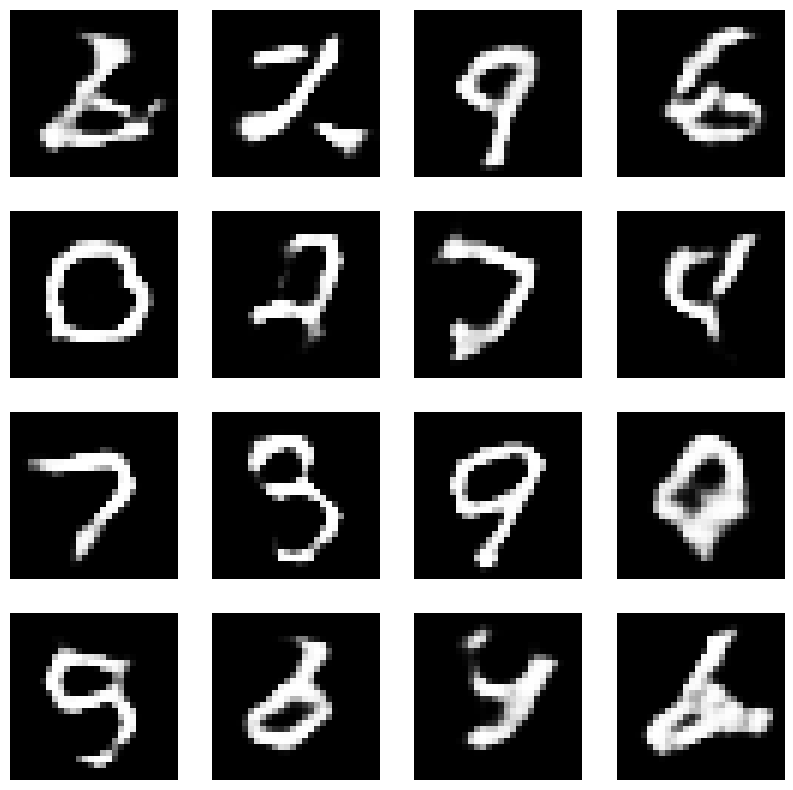

Epoch:  94


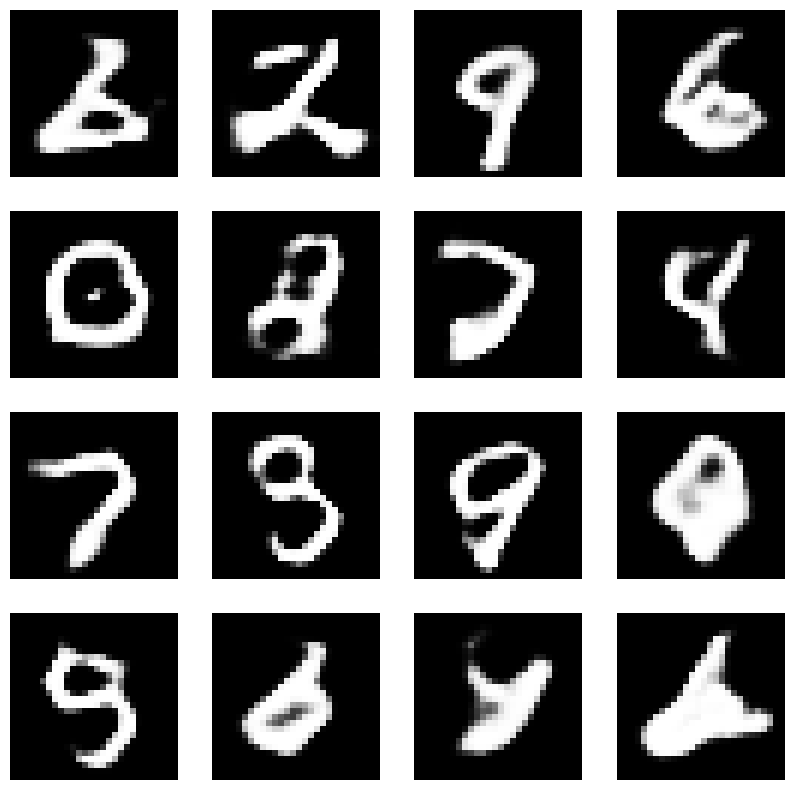

Epoch:  95


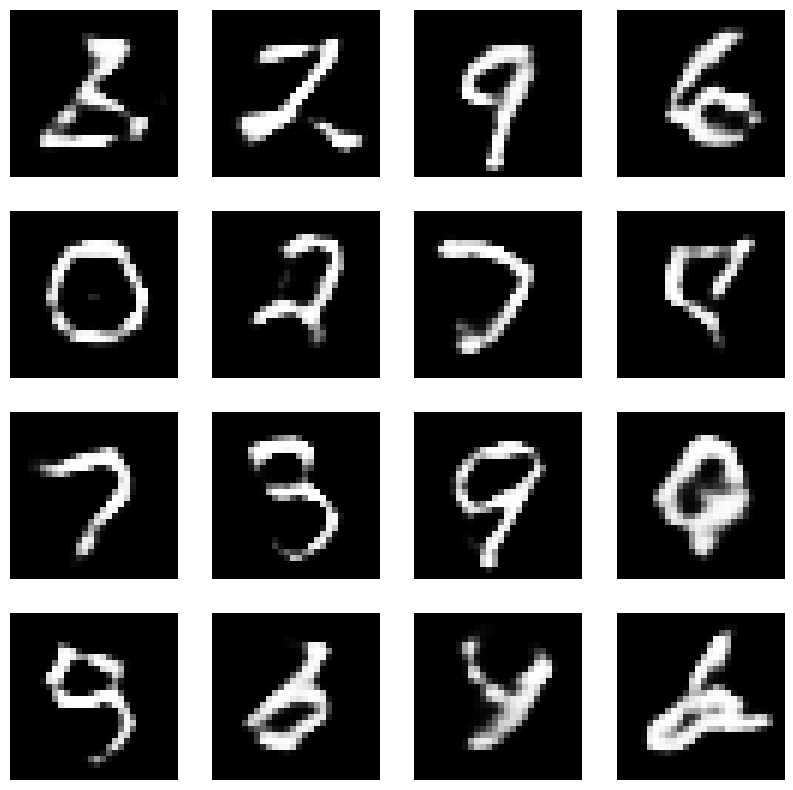

Epoch:  96


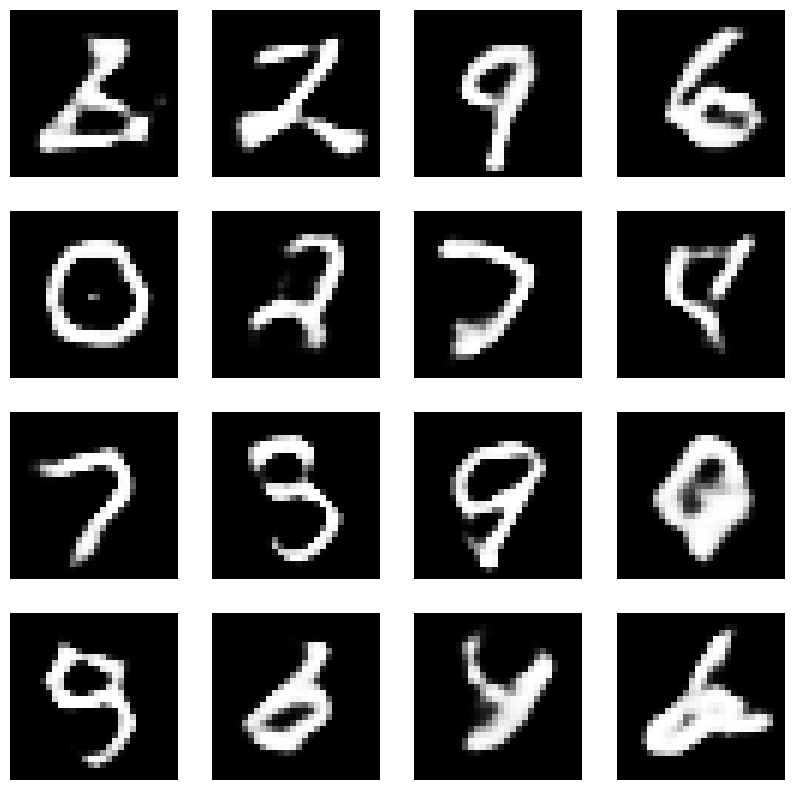

Epoch:  97


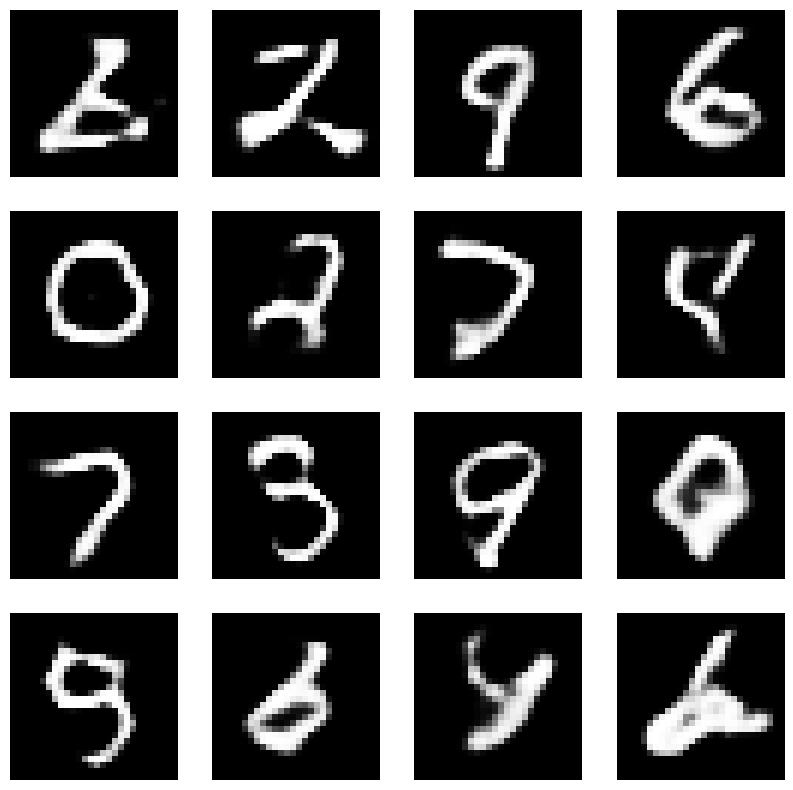

Epoch:  98


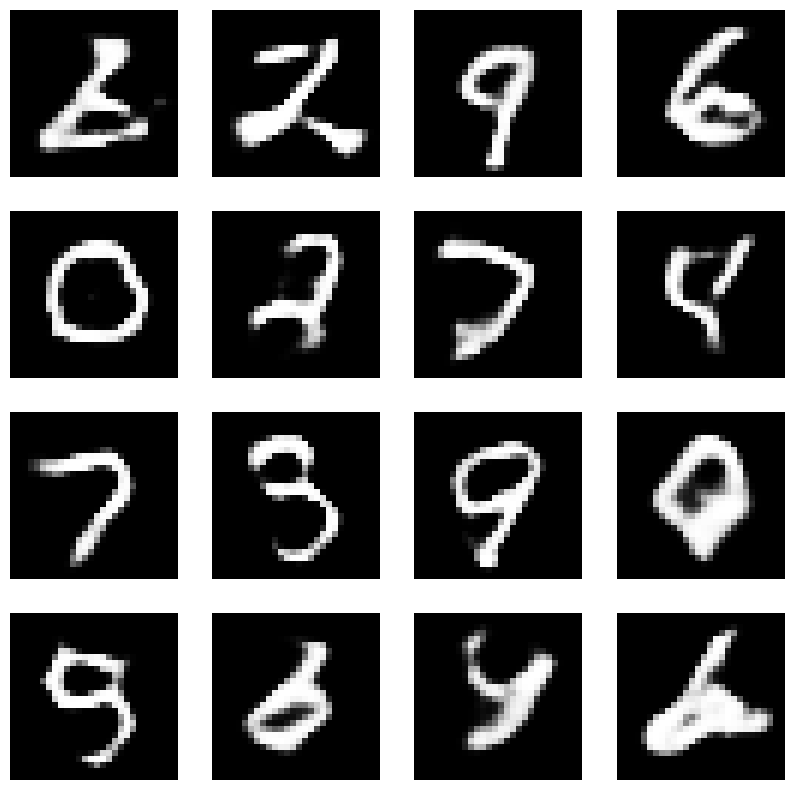

Epoch:  99


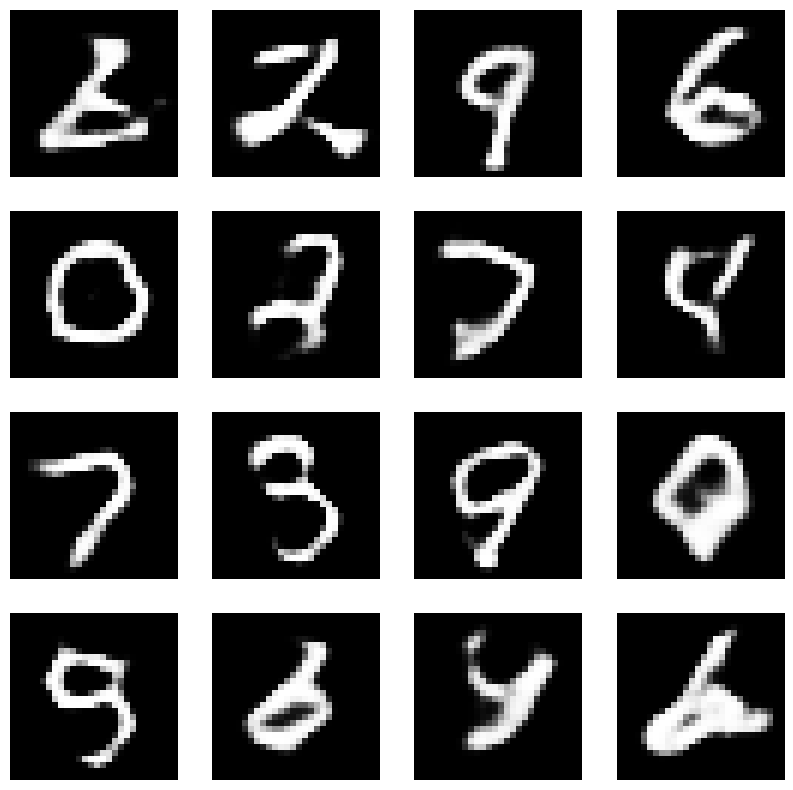

Epoch:  100


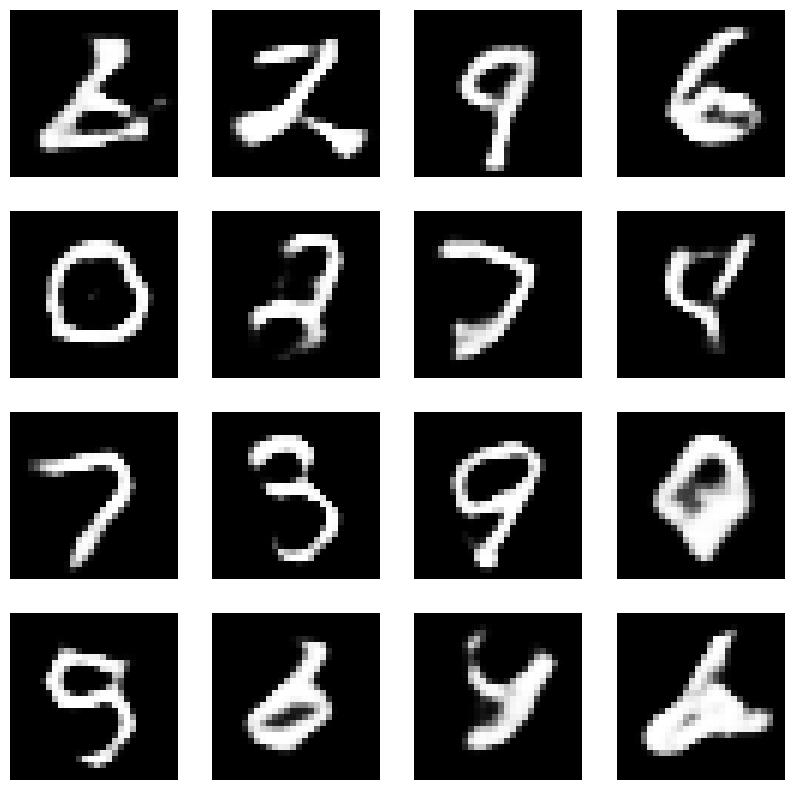

In [61]:
train_gan(X_train, epochs, test_images)